# 0. Dependencies
This notebook requires three dependencies to work properly, all three which are publicly available:
1. Jupyter kernel containing the python package dependencies below. The easiest way to install a functioning kernel is to follow the step-by-step explanation in notebook `0_resources.ipynb`.
2. Region sets which can be used to calculate FRIP. You can either supply your own (e.g. generate from peak calling on aggregate data from your samples, or previous experiments), or use the ENCODE SCREEN regions, which can be downloaded from `PUMATAC_dependencies` (see notebook `0_resources.ipynb`)
3. Aligned fragments files generated using either `PUMATAC` or `cellranger`.

In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import pycisTopic
import glob
import os
import pybiomart as pbm
import pandas as pd
import pickle
from pycisTopic.qc import *
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import palettable
import pypumatac as pum  # this loads the main functions needed in this notebook.
import pprint as pp
import polars as pl


%matplotlib inline
%load_ext jupyter_black

# 1. Run basic cisTopic analysis

Define which pipeline was used to generate your output using the variable `pipeline`. This can be either `PUMATAC`, `cellranger-atac` or `cellranger-arc`.

In [2]:
# pipeline = "PUMATAC"
# pipeline = "cellranger-atac"
pipeline = "cellranger-arc"

For `PUMATAC`, simply list the `PUMATAC` output directory, which will contain subdirectories for all samples.  
For `cellranger-atac` and `cellranger-arc`, list a master directory which contains the cellranger output directories. i.e. if you have 5 cellranger runs, put the output directories in one master directory, and redirect `output_dir` there.

In [3]:
output_dir = "outputs_new"

In [4]:
pum.list_files(output_dir, maxlevel=1)

outputs_new/
    body_2
    body_3_new
    body_1
    body_4_new
    body_2/
        outs
        SC_ATAC_GEX_COUNTER_CS
    body_3_new/
        outs
        SC_ATAC_GEX_COUNTER_CS
    body_1/
        outs
        SC_ATAC_GEX_COUNTER_CS
    body_4_new/
        outs
        SC_ATAC_GEX_COUNTER_CS


### Find paths to fragments
The following list comprehension should find fragments files in your `output_dir`.

In [5]:
if pipeline == "PUMATAC":
    fragments_paths_dict = {
        os.path.basename(x).split(".fragments.tsv.gz")[0]: x
        for x in sorted(glob.glob(f"{output_dir}/data/fragments/*fragments.tsv.gz"))
    }

elif pipeline == "cellranger-arc" or pipeline == "cellranger-atac":
    fragments_paths_dict = {
        x.split("/")[1]: x
        for x in sorted(glob.glob(f"{output_dir}/*/outs/atac_fragments.tsv.gz"))
    }

fragments_paths_dict

{'body_1': 'outputs_new/body_1/outs/atac_fragments.tsv.gz',
 'body_2': 'outputs_new/body_2/outs/atac_fragments.tsv.gz',
 'body_3_new': 'outputs_new/body_3_new/outs/atac_fragments.tsv.gz',
 'body_4_new': 'outputs_new/body_4_new/outs/atac_fragments.tsv.gz'}

### Define which genome should be used for each sample
Create a dummy `genome_dict` first. The dummy genome assigns `standard_genome` (e.g. dm6) to all samples by default. If some samples deviate, you can adjust where necessary (valid values for this notebook are `hg38`, `mm10` and `dm6`, if you work with other genomes, you can manually add gene annotation and regions as you please).

In [6]:
standard_genome = "dm6"

if pipeline == "PUMATAC":
    dummy_genome_dict = {
        os.path.basename(x).split(".fragments.tsv.gz")[0]: standard_genome
        for x in sorted(glob.glob(f"{output_dir}/data/fragments/*fragments.tsv.gz"))
    }
elif pipeline == "cellranger-arc" or pipeline == "cellranger-atac":
    dummy_genome_dict = {
        x.split("/")[1]: standard_genome
        for x in sorted(glob.glob(f"{output_dir}/*/outs/atac_fragments.tsv.gz"))
    }

dummy_genome_dict

{'body_1': 'dm6', 'body_2': 'dm6', 'body_3_new': 'dm6', 'body_4_new': 'dm6'}

You can then copy the `dumy_genome_dict` and manually set the real `genome_dict` here (replace `mm10` by `hg38` or `dm6` where necessary, or a custom genome if another species (see furhter):

In [7]:
genome_dict = {
    "body_1": "dm6",
    "body_2": "dm6",
    "body_3_new": "dm6",
    "body_4_new": "dm6",
}

Check if all samples are included:

In [8]:
if not set(genome_dict.keys()) == set(fragments_paths_dict.keys()):
    print("Warning, not all fragments files have genomes defined.")
else:
    print("Genomes defined for all fragments files!")

Genomes defined for all fragments files!


Create an inverse dictionary, listing the samples per genome.

In [9]:
inverse_genome_dict = {}
for sample, genome in genome_dict.items():
    if genome not in inverse_genome_dict:
        inverse_genome_dict[genome] = []
    inverse_genome_dict[genome].append(sample)

inverse_genome_dict

{'dm6': ['body_1', 'body_2', 'body_3_new', 'body_4_new']}

### Define sample aliases
We can also define a `sample_alias_dict` which defines short hand names for each sample which will be used in the titles of plots.

In [10]:
sample_alias_dict = {x: x for x in fragments_paths_dict.keys()}
sample_alias_dict

{'body_1': 'body_1',
 'body_2': 'body_2',
 'body_3_new': 'body_3_new',
 'body_4_new': 'body_4_new'}

Then, manually adjust to your liking

In [11]:
sample_alias_dict = {
    "body_1": "body_1",
    "body_2": "body_2",
    "body_3_new": "body_3_new",
    "body_4_new": "body_4_new",
}

### Download a gene annotation from biomart
We need gene annotations to calculate TSS enrichment of fragments later. The following code will work for `hg38`, `hg37`, `mm10` and `dm6`.

In [12]:
annotation_dict = pum.download_genome_annotation(inverse_genome_dict)

Loading cached genome annotation dm6_annotation.tsv


A genome annotation for `standard_genome` looks like so:

In [13]:
annotation_dict[standard_genome]

Chromosome     Start  Strand        Gene Transcript_type
0             2L  19190342       1         drl  protein_coding
1             2R  10879673      -1        Taf5  protein_coding
3             3R   7150968      -1        gfzf  protein_coding
4             3R   7147378      -1        gfzf  protein_coding
5             2R  22205593      -1        Alp7  protein_coding
...          ...       ...     ...         ...             ...
29745         3R  29248904      -1      SP1029  protein_coding
29746         2L   5724656       1     CG11030  protein_coding
29747         2L   2879112       1  betaggt-II  protein_coding
29749         3L  21962401       1        Chs2  protein_coding
29751         3R  10882188      -1        Tpc1  protein_coding

[19623 rows x 5 columns]

### Make sure that the chromosome names in your annotation match the chromosome names in your fragments files.
Depending on the genome index you use, the prefix `chr` may be omitted in your fragments files. You can check this via the following cell, which checks which chromosomes are present here. Note that this code can take a few minutes per fragments file.

In [14]:
check_fragments = False

if check_fragments:
    for sample, file in fragments_paths_dict.items():
        fragments_df = pum.read_bc_and_counts_from_fragments_file(file)
        print(
            sorted(
                fragments_df.select(pl.col("Chromosome").unique()).to_series().to_list()
            )
        )

If `chr` is not in the chromosome names, you can transform your annotation as such:

In [15]:
remove_chr = True

In [16]:
if remove_chr:
    for genome in annotation_dict.keys():
        annotation_dict[genome]["Chromosome"] = [
            x.replace("chr", "") for x in annotation_dict[genome]["Chromosome"]
        ]

In [17]:
annotation_dict[standard_genome]

Chromosome     Start  Strand        Gene Transcript_type
0             2L  19190342       1         drl  protein_coding
1             2R  10879673      -1        Taf5  protein_coding
3             3R   7150968      -1        gfzf  protein_coding
4             3R   7147378      -1        gfzf  protein_coding
5             2R  22205593      -1        Alp7  protein_coding
...          ...       ...     ...         ...             ...
29745         3R  29248904      -1      SP1029  protein_coding
29746         2L   5724656       1     CG11030  protein_coding
29747         2L   2879112       1  betaggt-II  protein_coding
29749         3L  21962401       1        Chs2  protein_coding
29751         3R  10882188      -1        Tpc1  protein_coding

[19623 rows x 5 columns]

If you want to use your own custom genome annotation, you can write an annotation in this format in a file named  `{genome}_annotation.tsv` in the current working directory.

### Define which regions to use to calculate fraction of reads in peaks
Ideally this should be cluster consensus peaks called on each sample individually, but for rough QC purposes, the ENCODE SCREEN regions suffice.  
We host a copy of these regions for mm10 and hg38 here https://resources.aertslab.org/papers/PUMATAC/PUMATAC_dependencies/regions/. For dm6, you can use the cisTarget regions: https://resources.aertslab.org/cistarget/regions/dm6__regulatory_regions.regionid-location.bed. If you want to use other regions, please add the path and the corresponding genome name as a value-key pair in `screen_path_dict` below.

In [18]:
screen_path_dict = {
    "hg38": "PUMATAC_dependencies/regions/V2.hg38-rDHS-Unfiltered.blacklisted.bed",
    "hg38_nochr": "PUMATAC_dependencies/regions/V2.hg38-rDHS-Unfiltered.blacklisted.NOCHR.bed",
    "mm10": "PUMATAC_dependencies/regions/V2.mm10-rDHS-Unfiltered.blacklisted.bed",
    "mm10_nochr": "PUMATAC_dependencies/regions/V2.mm10-rDHS-Unfiltered.blacklisted.NOCHR.bed",
    "dm6": "PUMATAC_dependencies/regions/dm6__regulatory_regions.regionid-location.bed",
    "dm6_nochr": "PUMATAC_dependencies/regions/dm6__regulatory_regions.regionid-location.NOCHR.bed",
}
screen_path_dict

{'hg38': 'PUMATAC_dependencies/regions/V2.hg38-rDHS-Unfiltered.blacklisted.bed',
 'hg38_nochr': 'PUMATAC_dependencies/regions/V2.hg38-rDHS-Unfiltered.blacklisted.NOCHR.bed',
 'mm10': 'PUMATAC_dependencies/regions/V2.mm10-rDHS-Unfiltered.blacklisted.bed',
 'mm10_nochr': 'PUMATAC_dependencies/regions/V2.mm10-rDHS-Unfiltered.blacklisted.NOCHR.bed',
 'dm6': 'PUMATAC_dependencies/regions/dm6__regulatory_regions.regionid-location.bed',
 'dm6_nochr': 'PUMATAC_dependencies/regions/dm6__regulatory_regions.regionid-location.NOCHR.bed'}

In [19]:
if remove_chr:
    genome_adjusted = genome + "_nochr"
else:
    genome_adjusted = genome

if pipeline == "PUMATAC":
    regions_paths_dict = {
        x: screen_path_dict[genome_adjusted] for x in fragments_paths_dict.keys()
    }
elif pipeline == "cellranger-arc" or pipeline == "cellranger-atac":
    regions_paths_dict = {
        x: screen_path_dict[genome_adjusted] for x in fragments_paths_dict.keys()
    }

regions_paths_dict

{'body_1': 'PUMATAC_dependencies/regions/dm6__regulatory_regions.regionid-location.NOCHR.bed',
 'body_2': 'PUMATAC_dependencies/regions/dm6__regulatory_regions.regionid-location.NOCHR.bed',
 'body_3_new': 'PUMATAC_dependencies/regions/dm6__regulatory_regions.regionid-location.NOCHR.bed',
 'body_4_new': 'PUMATAC_dependencies/regions/dm6__regulatory_regions.regionid-location.NOCHR.bed'}

Again, if you want, you can manually edit this dictionary and substitute your own regions.

### Run cisTopic quality control tools
cisTopic has a suite of functions which calculate per-barcode quality metrics such as number of (unique) fragments, TSS enrichment, fraction of fragments in peaks and so on. Make a directory for cisTopic output:

In [20]:
cistopic_qc_out = "cistopic_qc_out"
if not os.path.exists(cistopic_qc_out):
    os.makedirs(cistopic_qc_out)

Determine which fragments files have already gone through cisTopic QC (in case you ran this notebook before)

In [21]:
fragments_sub_dict = {}
regions_sub_dict = {}
for sample in fragments_paths_dict.keys():
    metadata_file = os.path.join(cistopic_qc_out, sample + "__metadata_bc.pkl")
    print(f"Checking if {metadata_file} exist...")
    if os.path.exists(metadata_file):
        print("\tMetadata exists! Skipping...")
    else:
        fragments_sub_dict[sample] = fragments_paths_dict[sample]
        print("\tMetadata does not exist, adding to subdict to generate")

regions_sub_dict = {x: regions_paths_dict[x] for x in sorted(fragments_sub_dict.keys())}
regions_sub_dict

Checking if cistopic_qc_out/body_1__metadata_bc.pkl exist...
	Metadata exists! Skipping...
Checking if cistopic_qc_out/body_2__metadata_bc.pkl exist...
	Metadata exists! Skipping...
Checking if cistopic_qc_out/body_3_new__metadata_bc.pkl exist...
	Metadata exists! Skipping...
Checking if cistopic_qc_out/body_4_new__metadata_bc.pkl exist...
	Metadata exists! Skipping...


{}

Then execute cisTopic. The following code will run pycisTopic's QC toolbox on the fragments files provided above. It does so in blocks, where the number of samples per block is defined by `n_cores`. For example, if you have 64 samples, and you define `n_cores = 8`, the following loop will call ray 8 times and run 8 samples each time.

In [22]:
ray.shutdown()

In [23]:
n_cores = 8
for genome, samples in inverse_genome_dict.items():
    if regions_sub_dict != {}:
        samples_sub = list(set(regions_sub_dict.keys()).intersection(samples))
        blocks = [
            samples_sub[i : i + n_cores] for i in range(0, len(samples_sub), n_cores)
        ]
        pp.pprint(blocks)
        for samples_torun_in_block in blocks:
            fragments_sub_dict_block = {
                key: fragments_sub_dict[key] for key in samples_torun_in_block
            }
            regions_sub_dict_block = {
                key: regions_sub_dict[key] for key in samples_torun_in_block
            }
            print(f"Running samples {samples_torun_in_block} for genome {genome}")

            metadata_bc_dict, profile_data_dict = compute_qc_stats(
                fragments_dict=fragments_sub_dict_block,
                tss_annotation=annotation_dict[genome],
                stats=[
                    "barcode_rank_plot",
                    "duplicate_rate",
                    "insert_size_distribution",
                    "profile_tss",
                    "frip",
                ],
                label_list=None,
                path_to_regions=regions_sub_dict_block,
                n_cpu=n_cores,
                valid_bc=None,
                n_frag=10,
                n_bc=None,
                tss_flank_window=2000,
                tss_window=50,
                tss_minimum_signal_window=100,
                tss_rolling_window=10,
                # min_norm=0.2,
                remove_duplicates=True,
            )

            ray.shutdown()
            print(f"Done, writing files to {cistopic_qc_out}...")
            for sample in sorted(metadata_bc_dict.keys()):
                metadata_bc_dict[sample]["sample_id"] = sample
                metadata_bc_dict[sample].index = [
                    x + "___" + sample for x in list(metadata_bc_dict[sample].index)
                ]
                with open(
                    os.path.join(cistopic_qc_out, f"{sample}__metadata_bc.pkl"), "wb"
                ) as f:
                    pickle.dump(metadata_bc_dict[sample], f, protocol=4)

                with open(
                    os.path.join(cistopic_qc_out, f"{sample}__profile_data.pkl"), "wb"
                ) as f:
                    pickle.dump(profile_data_dict[sample], f, protocol=4)
    else:
        print("All samples already processed.")

All samples already processed.


We have now calculated various QC metrics and can proceed. `{sample}__metadata_bc.pkl` contains barcode level quality metrics such as number of fragments, TSS enrichment, ... per barcode. `__profile_data.pkl` contains the aggregate accessibility profile around TSS for every barcode.

In [24]:
sorted(os.listdir(cistopic_qc_out))

['body_1__metadata_bc.pkl',
 'body_1__profile_data.pkl',
 'body_2__metadata_bc.pkl',
 'body_2__profile_data.pkl',
 'body_3_new__metadata_bc.pkl',
 'body_3_new__profile_data.pkl',
 'body_4_new__metadata_bc.pkl',
 'body_4_new__profile_data.pkl']

### Filter cells from background noise
We then filter true cells (high TSS enrichment, and high number of unique fragments \[in peaks\]).

In [25]:
import seaborn as sns
import pprint as pp

Then, find the `__metadata_bc.pkl` files we just generated using cisTopic:

In [26]:
metadata_bc_pkl_path_dict = {
    os.path.basename(x).split("__metadata_bc.pkl")[0]: x
    for x in sorted(glob.glob(f"{cistopic_qc_out}/*metadata_bc.pkl"))
}
metadata_bc_pkl_path_dict

{'body_1': 'cistopic_qc_out/body_1__metadata_bc.pkl',
 'body_2': 'cistopic_qc_out/body_2__metadata_bc.pkl',
 'body_3_new': 'cistopic_qc_out/body_3_new__metadata_bc.pkl',
 'body_4_new': 'cistopic_qc_out/body_4_new__metadata_bc.pkl'}

Concatenate to one large `metadata_bc_df_all`:

In [27]:
metadata_bc_df_all = pd.DataFrame()
for sample in metadata_bc_pkl_path_dict.keys():
    with open(metadata_bc_pkl_path_dict[sample], "rb") as fh:
        metadata_bc_df = pickle.load(fh)
        metadata_bc_df_all = pd.concat([metadata_bc_df_all, metadata_bc_df])
        print(f"Added {sample} metadata_bc_df")

Added body_1 metadata_bc_df
Added body_2 metadata_bc_df
Added body_3_new metadata_bc_df
Added body_4_new metadata_bc_df


Calculate global maxima for variables, will be used to scale plots later. The idea is that plots for different samples will have the same axis limits so they can be compared directly visually.

In [28]:
max_dict = {}
min_dict = {}
for stat in metadata_bc_df_all.columns:
    max_dict[stat] = metadata_bc_df_all[stat].max()
    min_dict[stat] = metadata_bc_df_all[stat].min()

pp.pprint(min_dict)
pp.pprint(max_dict)

{'Dupl_nr_frag': 0,
 'Dupl_rate': 0.0,
 'FRIP': 0.0,
 'Log_total_nr_frag': 1.0413926851582251,
 'Log_unique_nr_frag': 1.0413926851582251,
 'TSS_enrichment': 0.0,
 'Total_nr_frag': 11,
 'Total_nr_frag_in_regions': 0,
 'Unique_nr_frag': 11,
 'Unique_nr_frag_in_regions': 0,
 'sample_id': 'body_1'}
{'Dupl_nr_frag': 1789668,
 'Dupl_rate': 0.7777777777777778,
 'FRIP': 1.0,
 'Log_total_nr_frag': 6.501369870324171,
 'Log_unique_nr_frag': 6.140696552546415,
 'TSS_enrichment': 13.651711874572339,
 'Total_nr_frag': 3172268,
 'Total_nr_frag_in_regions': 2083422,
 'Unique_nr_frag': 1382600,
 'Unique_nr_frag_in_regions': 946122,
 'sample_id': 'body_4_new'}


Now, we will apply Otsu's algorithm on all cells with more than `standard_min_x_val` fragments and a higher than `standard_min_y_val` TSS enrichment. For some samples, the standard minimum values might not produce good results, so these can be edited here if you want. For high quality samples, the standard values should work nicely. By default, Otsu's algorithm is applied to all cell barcodes with more than 100 barcodes and a TSS enrichment of 1. For most (high quality) samples, this works well. However, for some samples, especially samples with a high amount of low-quality barcodes, a higher threshold may be necessary. This can be done using the following dictionary:

In [29]:
samples_tech_dict = {x: "10x_atac" for x in fragments_paths_dict.keys()}
samples_tech_dict

{'body_1': '10x_atac',
 'body_2': '10x_atac',
 'body_3_new': '10x_atac',
 'body_4_new': '10x_atac'}

In [30]:
standard_min_x_val = 100
standard_min_y_val = 1
min_otsu_frags_dict = {}
min_otsu_tss_dict = {}
for metadata_bc_pkl_path in sorted(metadata_bc_pkl_path_dict.keys()):
    sample = metadata_bc_pkl_path.split("/")[-1].split("__metadata_bc.pkl")[0]
    tech = samples_tech_dict[sample]
    if tech == "ddseq":
        min_otsu_frags_dict[sample] = 300
    elif tech == "hydrop":
        min_otsu_frags_dict[sample] = 300
    else:
        min_otsu_frags_dict[sample] = standard_min_x_val

    if tech == "s3atac":
        min_otsu_tss_dict[sample] = 0
    else:
        min_otsu_tss_dict[sample] = standard_min_y_val

pp.pprint(min_otsu_frags_dict)
pp.pprint(min_otsu_tss_dict)

{'body_1': 100, 'body_2': 100, 'body_3_new': 100, 'body_4_new': 100}
{'body_1': 1, 'body_2': 1, 'body_3_new': 1, 'body_4_new': 1}


And here, we actually apply the algorithm in a loop:

In [31]:
kde = False

In [32]:
from IPython.display import Image, display

In [33]:
if not os.path.exists("plots_qc"):
    os.mkdir("plots_qc")
if not os.path.exists("selected_barcodes"):
    os.mkdir("selected_barcodes")

selected_barcodes/body_1_bc_passing_filters_otsu.pkl bc passing filters exists, skipping...


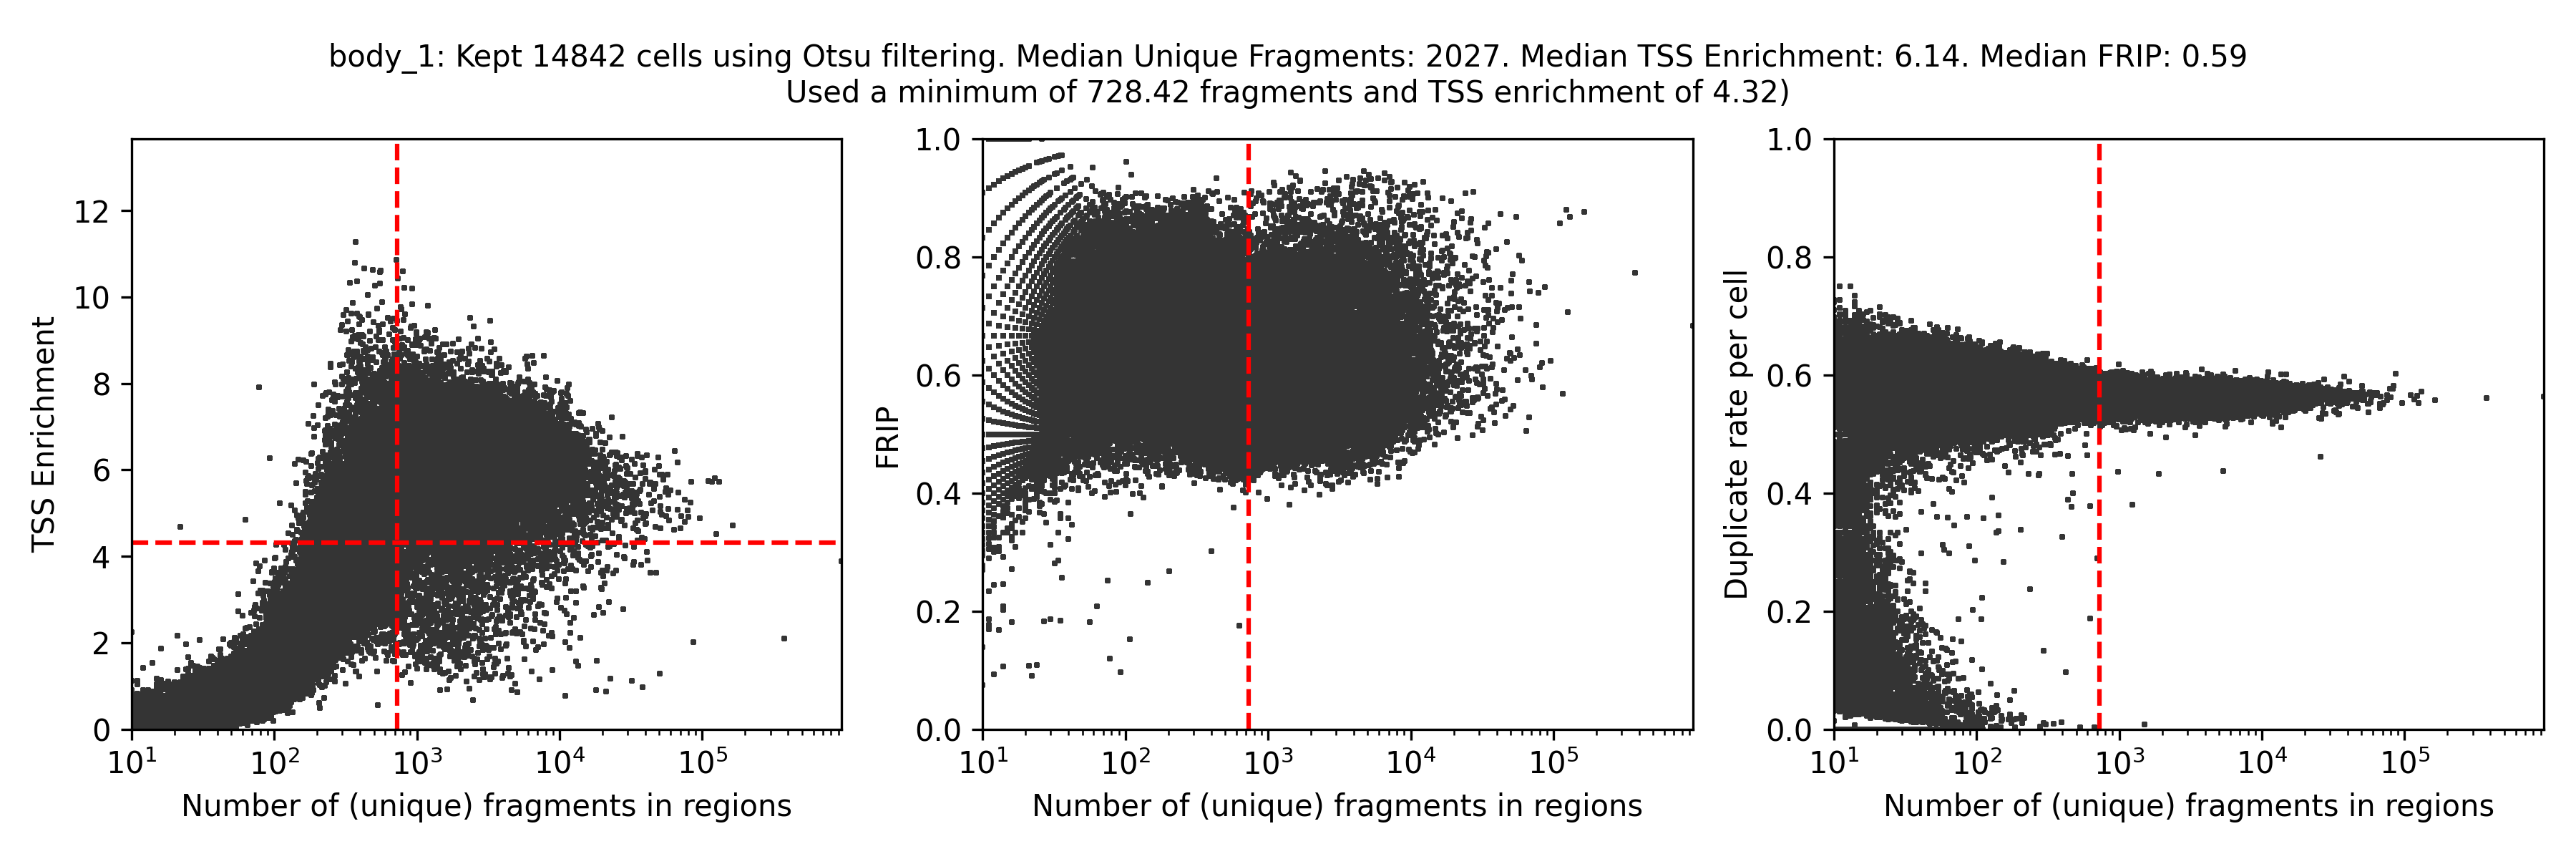

selected_barcodes/body_2_bc_passing_filters_otsu.pkl bc passing filters exists, skipping...


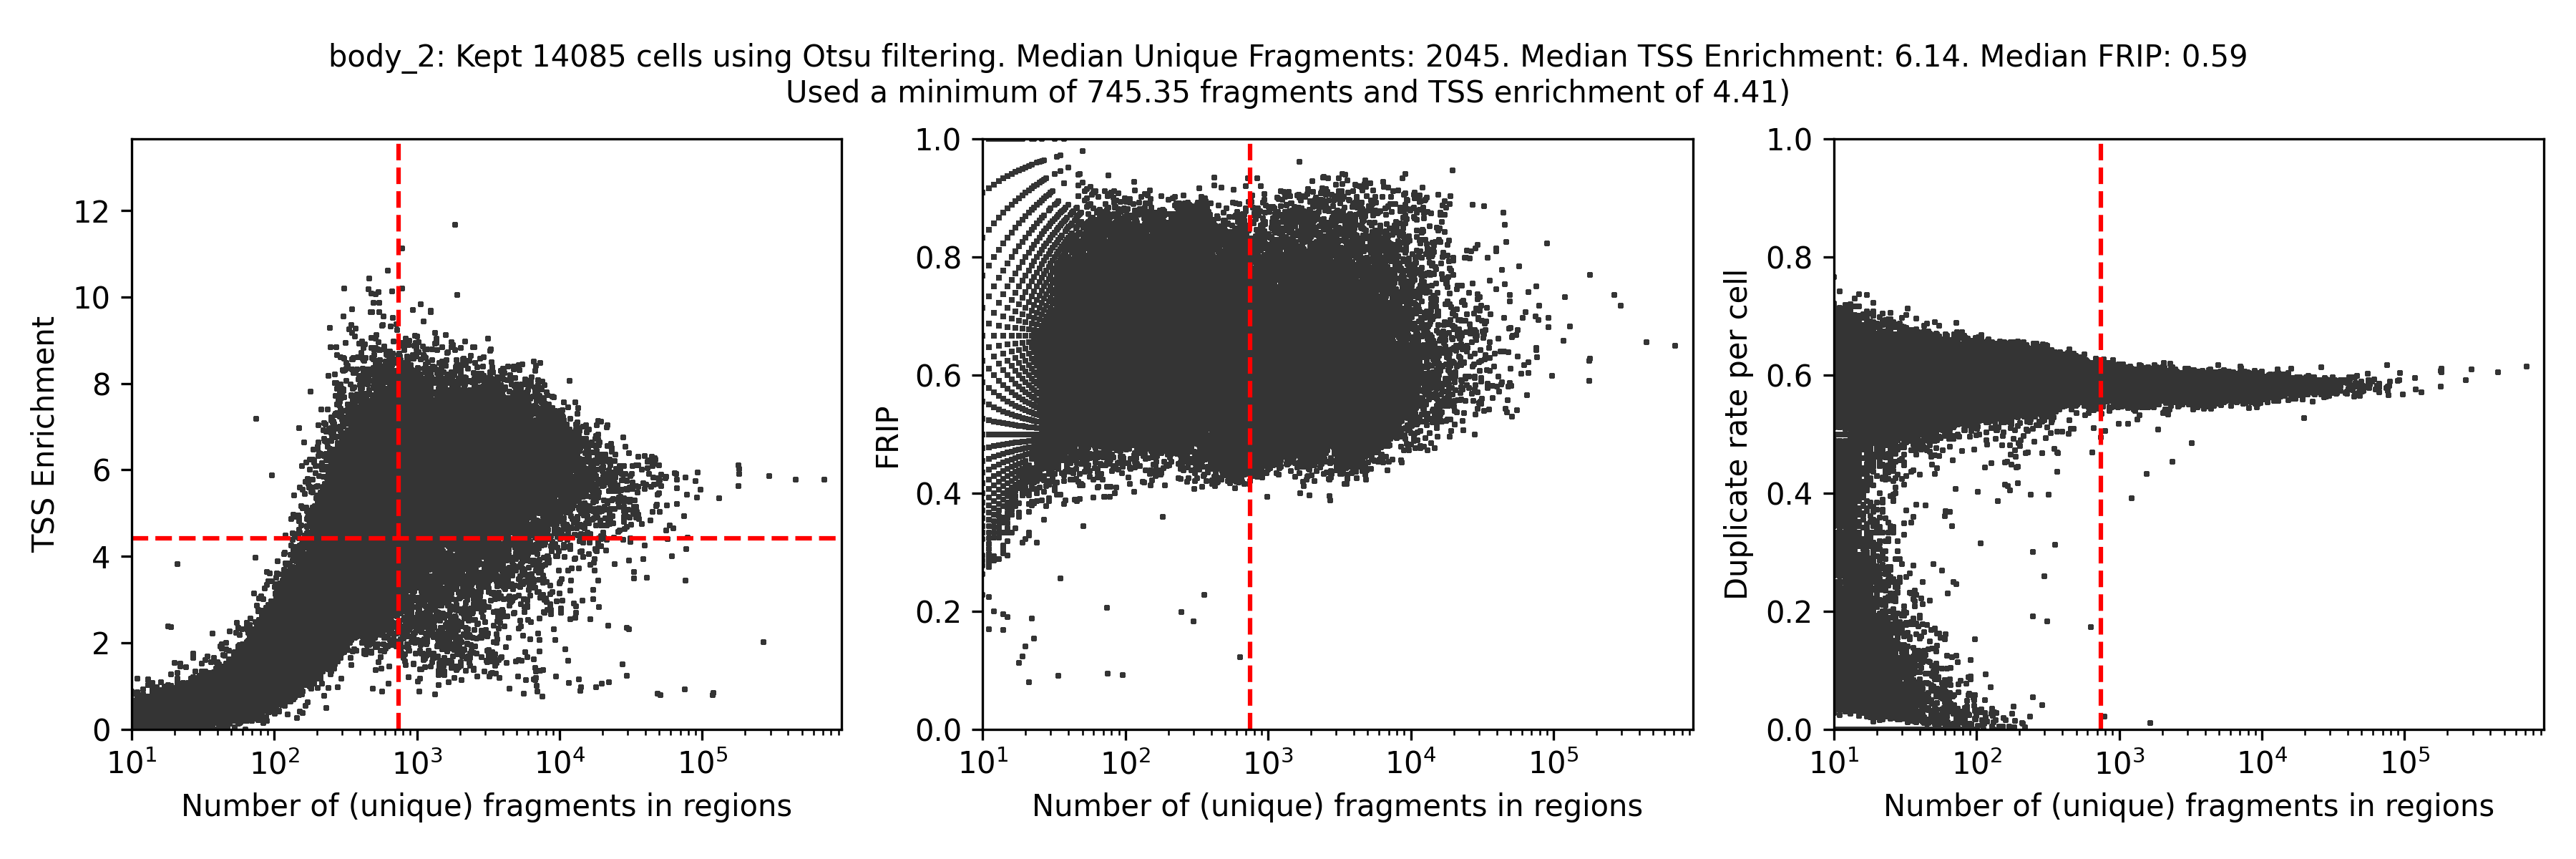

selected_barcodes/body_3_new_bc_passing_filters_otsu.pkl bc passing filters exists, skipping...


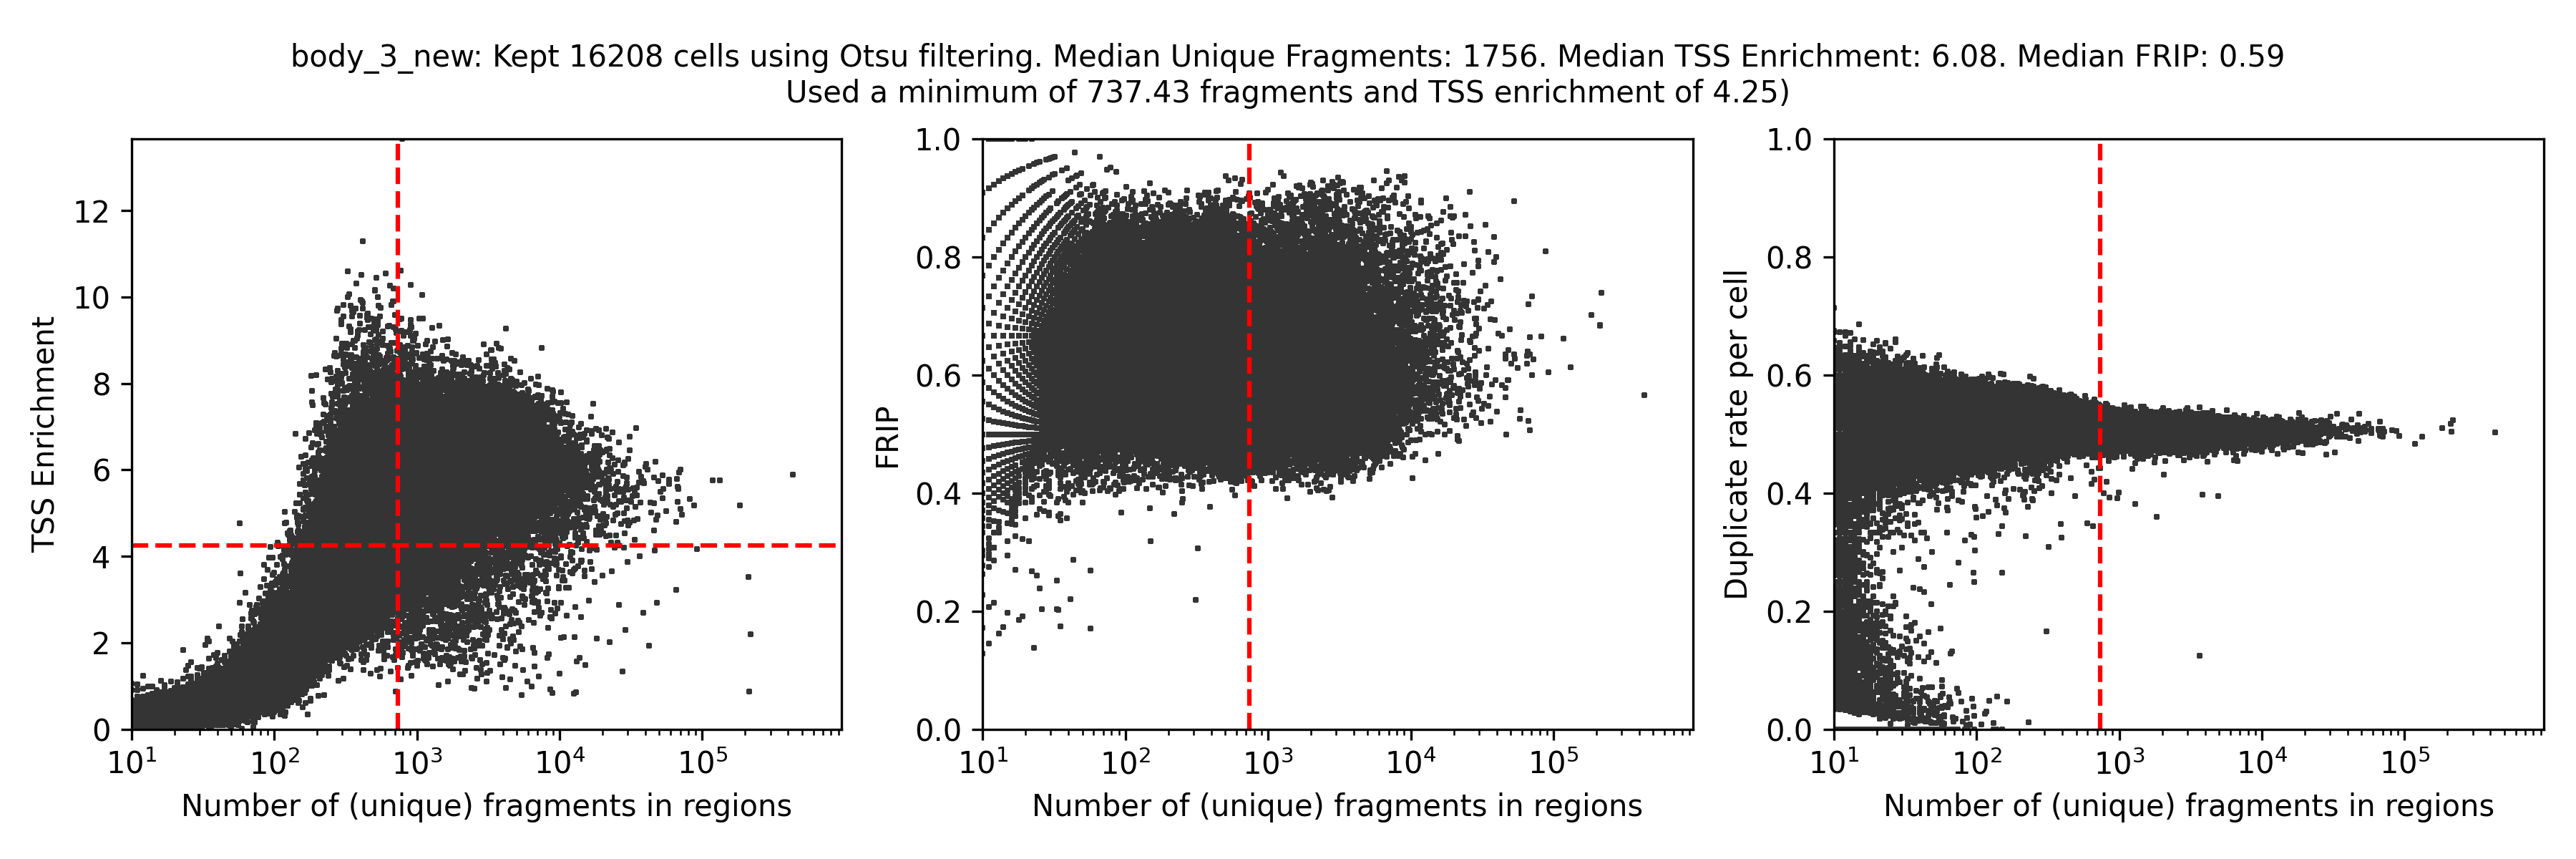

selected_barcodes/body_4_new_bc_passing_filters_otsu.pkl bc passing filters exists, skipping...


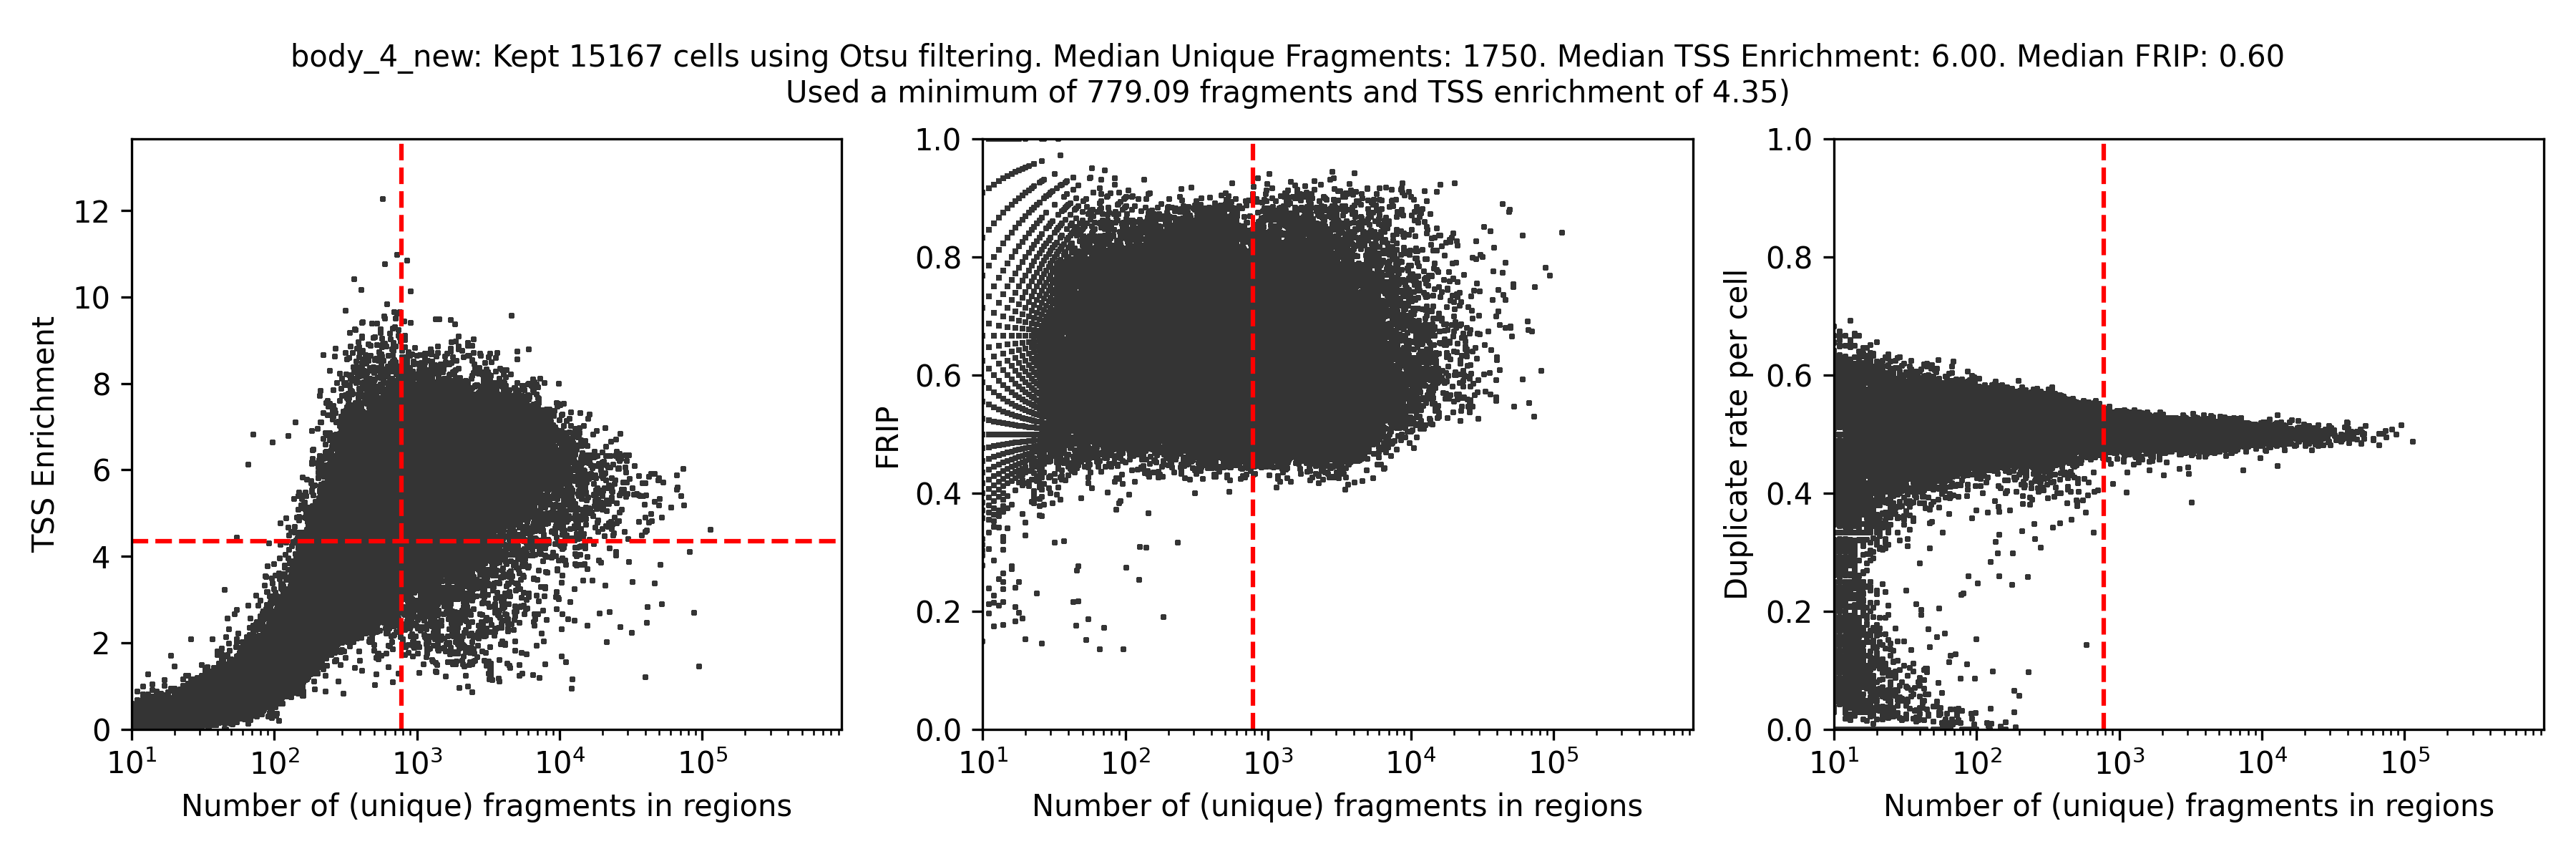

In [34]:
for sample in metadata_bc_pkl_path_dict.keys():
    pkl_path = f"selected_barcodes/{sample}_bc_passing_filters_otsu.pkl"
    if os.path.exists(pkl_path):
        print(f"{pkl_path} bc passing filters exists, skipping...")
        display(Image(filename=f"plots_qc/{sample}_qc_otsu.png"))

    else:
        print(f"{pkl_path} bc passing filters does not exist yet, generating...")
        print(f"\tLoading {metadata_bc_pkl_path_dict[sample]}")
        with open(metadata_bc_pkl_path_dict[sample], "rb") as fh:
            metadata_bc_df = pickle.load(fh)

        print(f"\tFiltering cells and generating QC plots.")
        if not sample in min_otsu_frags_dict.keys():
            print(
                f"\t{sample} not in minimum dict! Using standard value of {standard_min_x_val}"
            )
            min_x_val = standard_min_x_val
            min_y_val = standard_min_y_val
        else:
            min_x_val = min_otsu_frags_dict[sample]
            min_y_val = min_otsu_tss_dict[sample]

        bc_passing_filters, fig = pum.plot_qc(
            sample=sample,
            sample_alias=sample_alias_dict[sample],
            min_dict=min_dict,
            max_dict=max_dict,
            metadata_bc_df=metadata_bc_df,
            include_kde=kde,
            min_x_val=min_x_val,
            min_y_val=min_y_val,
        )

        plt.tight_layout()
        plt.savefig(f"plots_qc/{sample}_qc_otsu.png", dpi=300, facecolor="white")
        plt.show()
        plt.close()

        print(f"\tSaving...")
        with open(
            f"selected_barcodes/{sample}_bc_passing_filters_otsu.pkl", "wb"
        ) as fh:
            pickle.dump(bc_passing_filters, fh)
        fh.close()

        fh = open(f"selected_barcodes/{sample}_bc_passing_filters_otsu.txt", "w")
        for bc in list(bc_passing_filters):
            fh.write(bc + "\n")
        fh.close()

        metadata_bc_df.loc[bc_passing_filters].to_csv(
            f"selected_barcodes/{sample}_metadata_bc_df.tsv", sep="\t"
        )

# Plot profile data

In [35]:
profile_data_pkl_path_dict = {
    os.path.basename(x).split("__profile_data.pkl")[0]: x
    for x in sorted(glob.glob(f"{cistopic_qc_out}/*__profile_data.pkl"))
}
profile_data_pkl_path_dict

{'body_1': 'cistopic_qc_out/body_1__profile_data.pkl',
 'body_2': 'cistopic_qc_out/body_2__profile_data.pkl',
 'body_3_new': 'cistopic_qc_out/body_3_new__profile_data.pkl',
 'body_4_new': 'cistopic_qc_out/body_4_new__profile_data.pkl'}

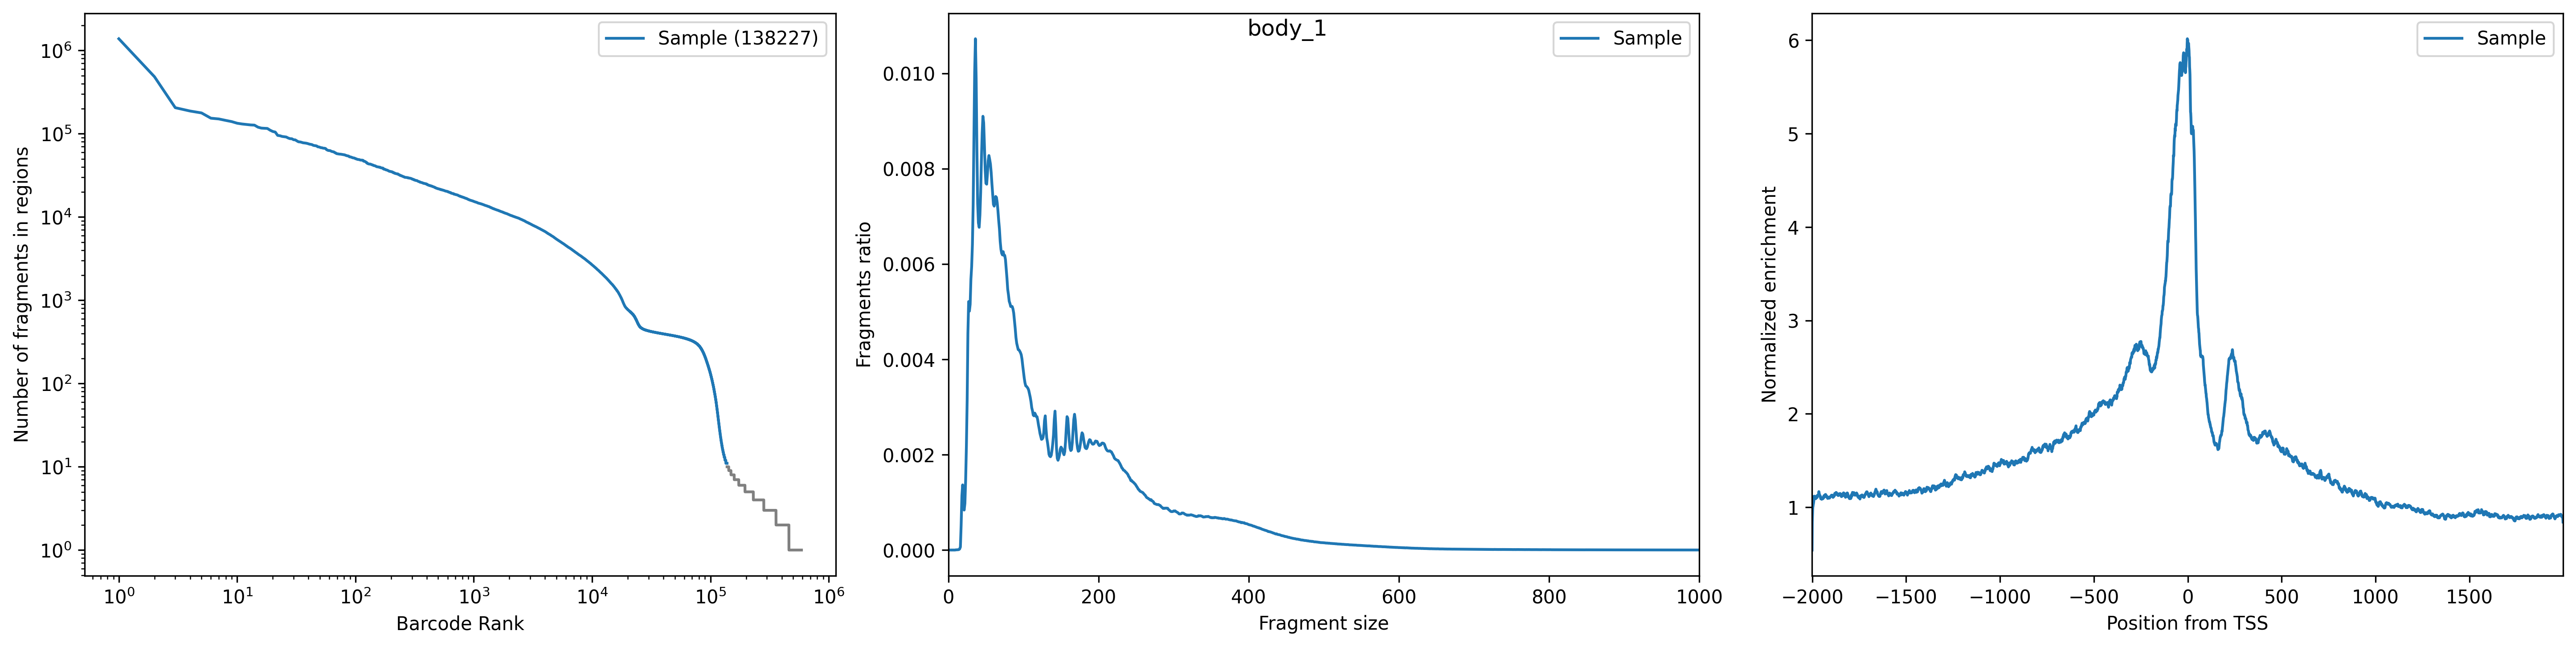

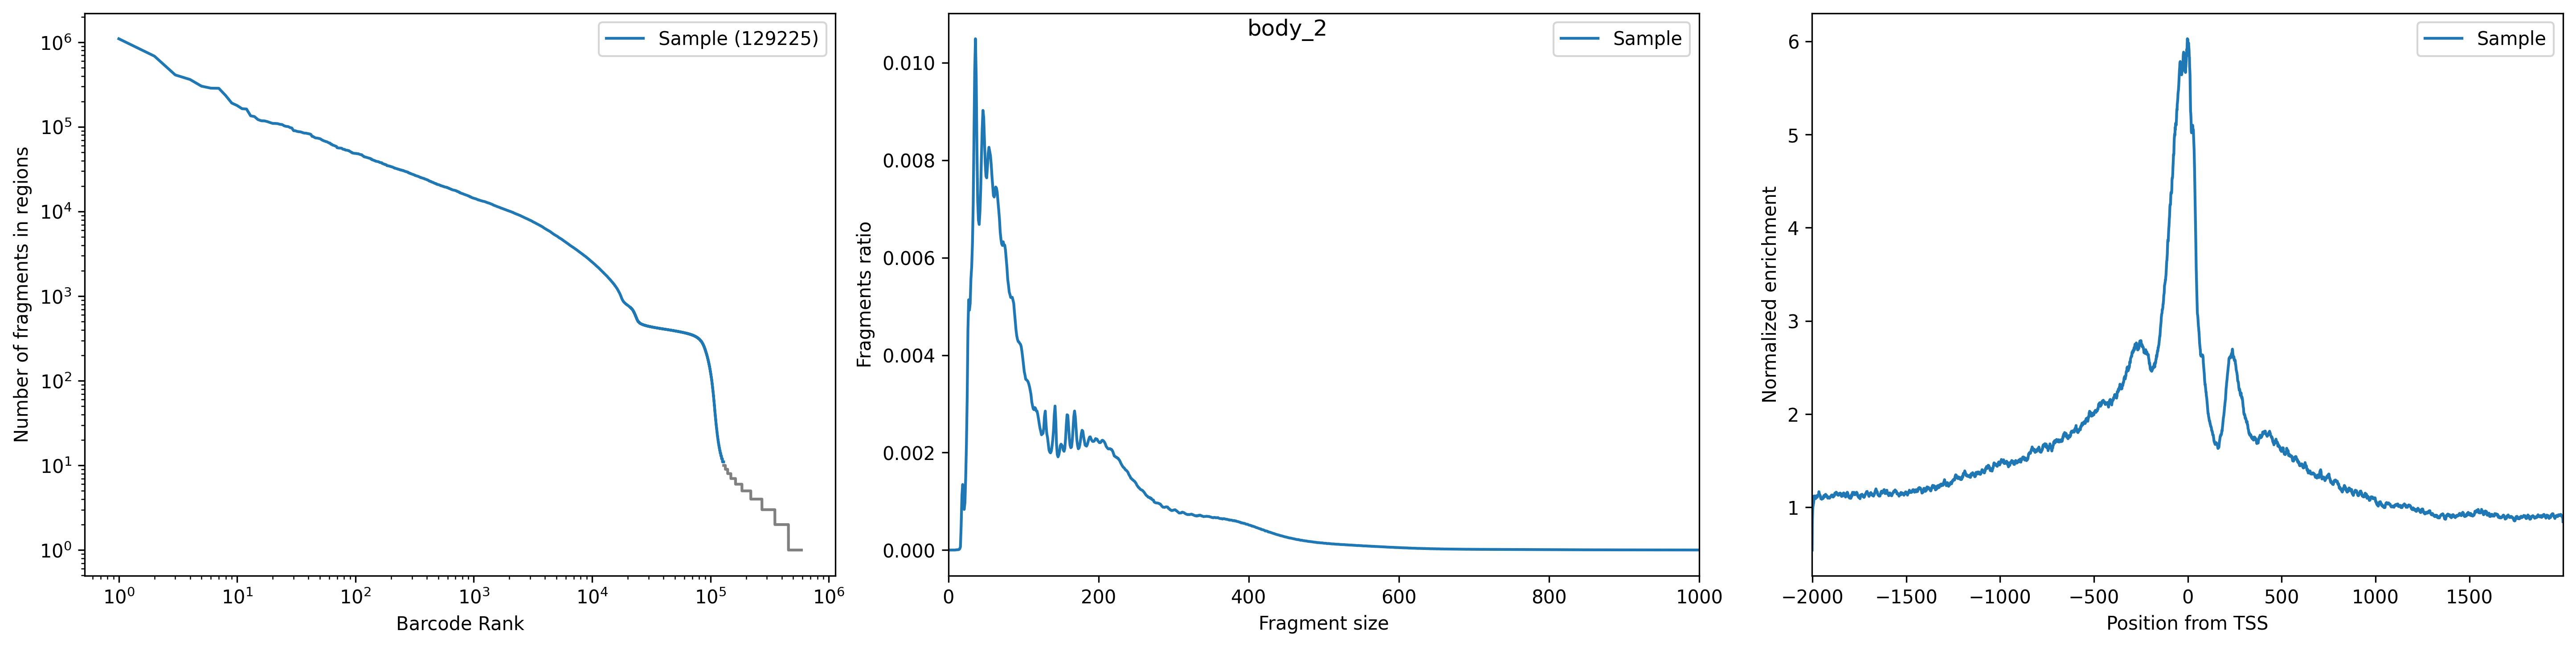

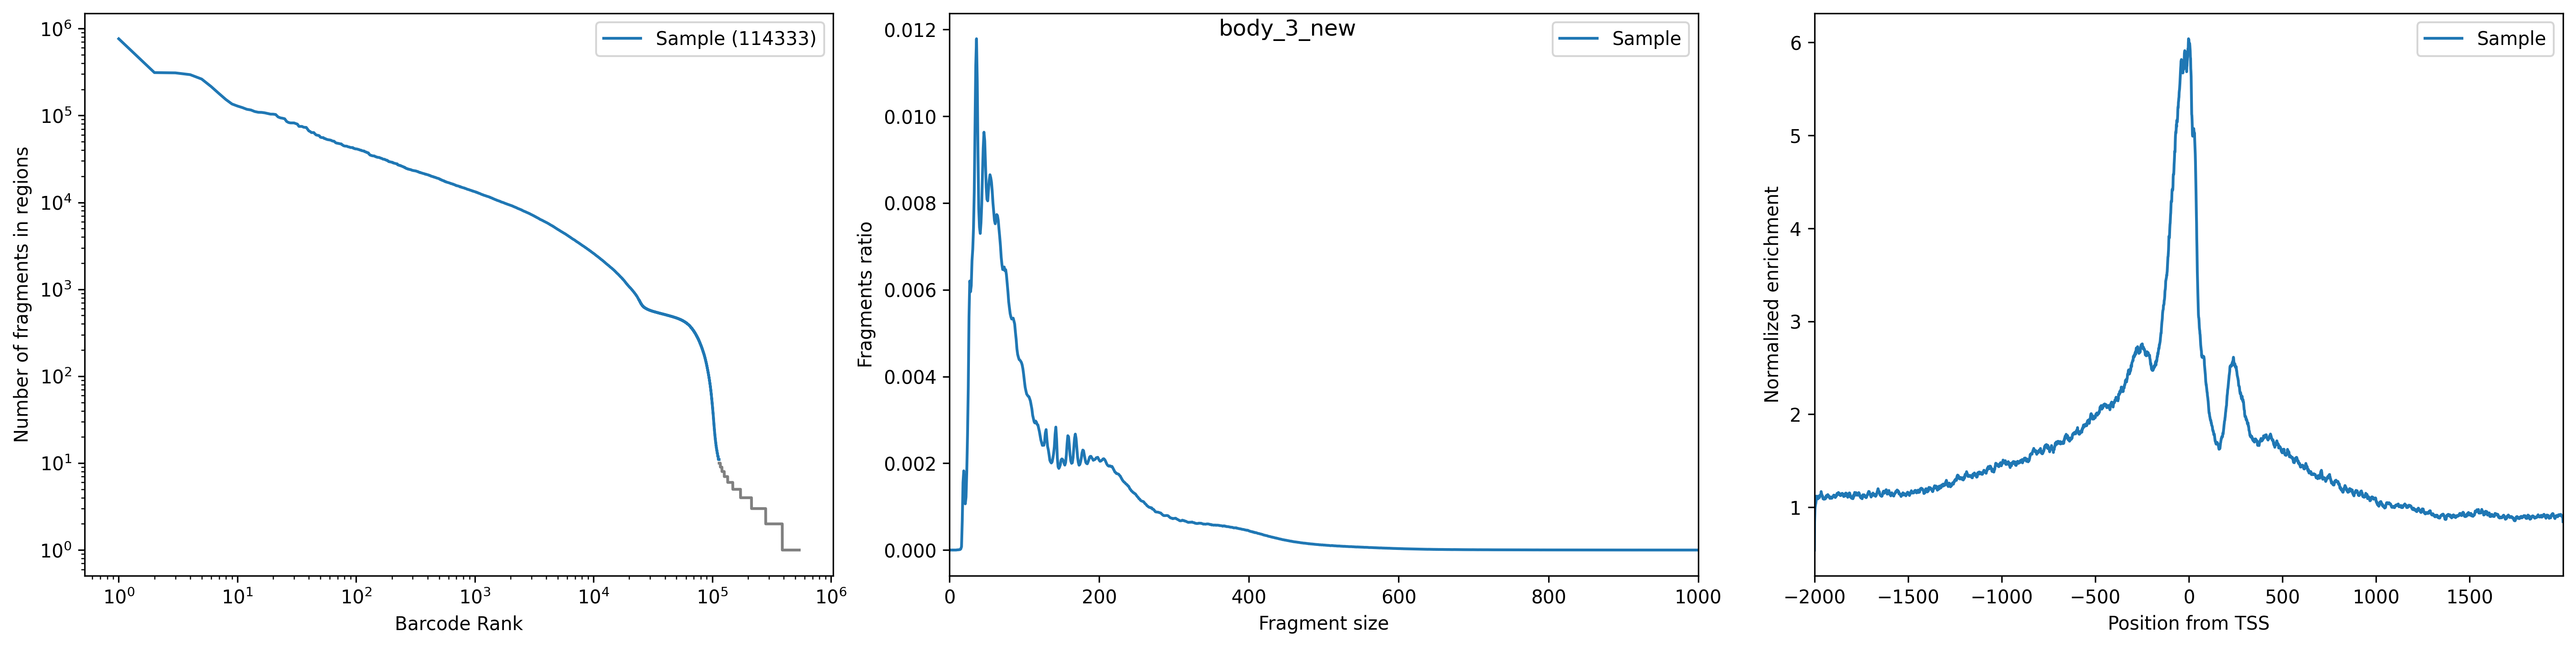

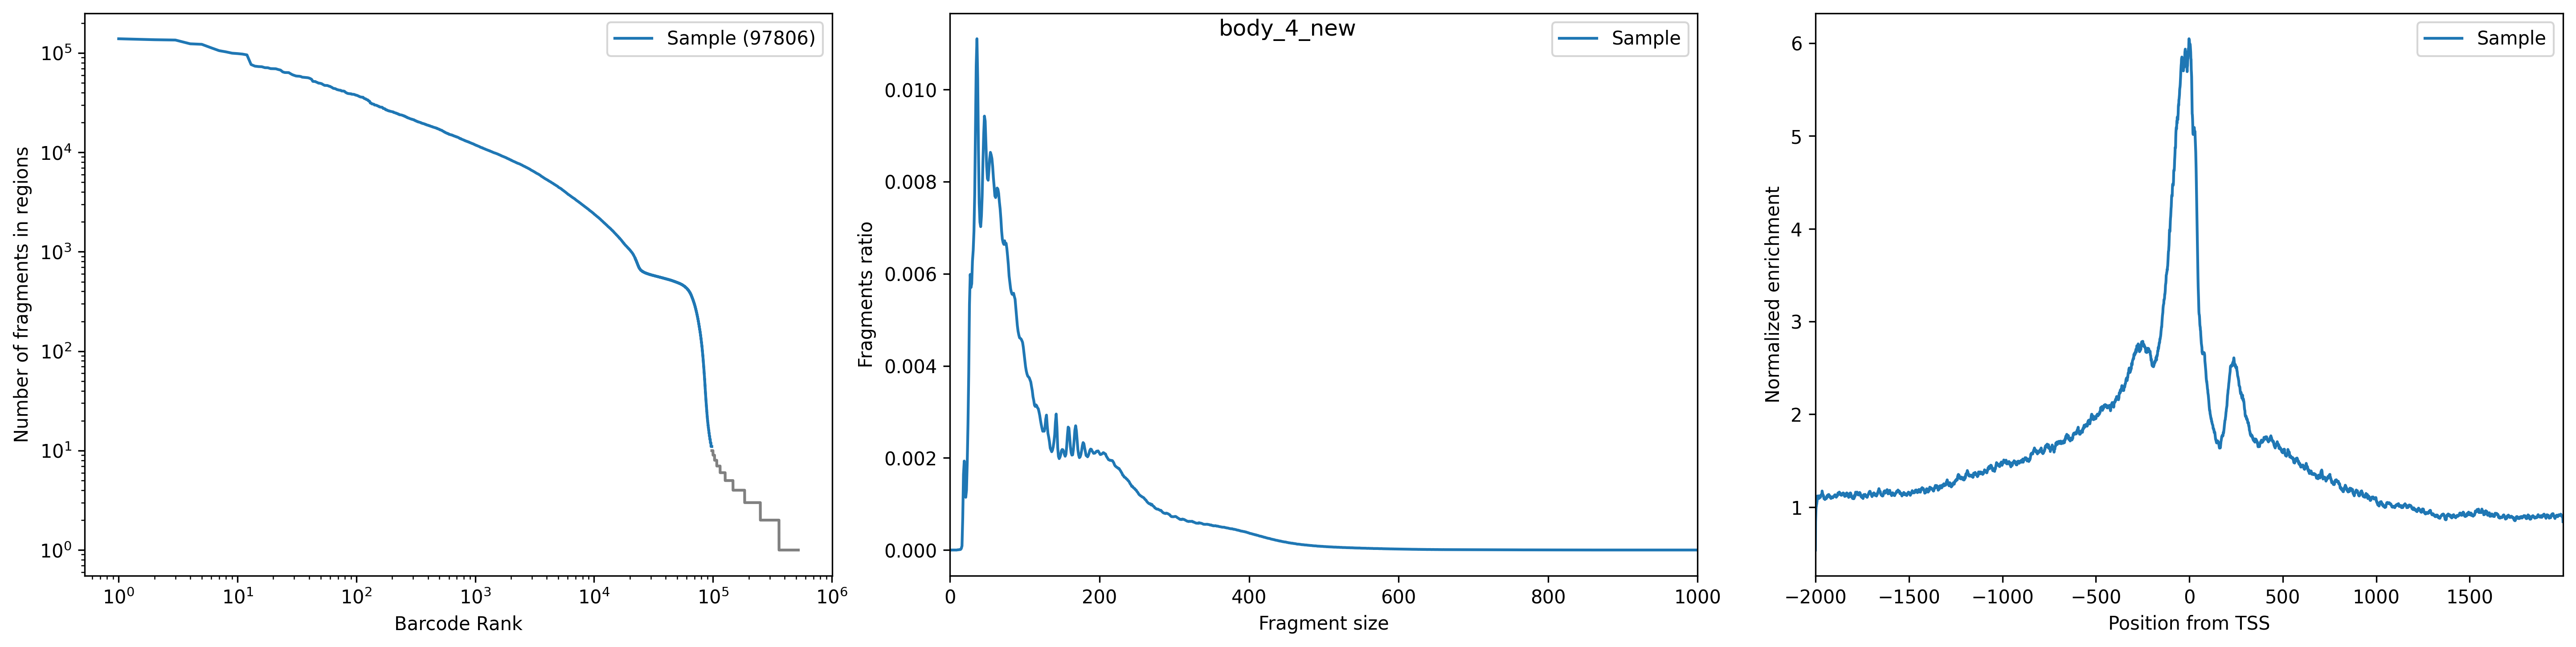

In [36]:
for sample, path in profile_data_pkl_path_dict.items():
    if not os.path.exists(f"plots_qc/{sample}_profile_metrics.png"):
        with open(path, "rb") as fh:
            profile_data_dict = pickle.load(fh)
        with warnings.catch_warnings():
            warnings.simplefilter(action="ignore", category=FutureWarning)
            plot_sample_metrics(
                profile_data_dict,
                ncol=3,
                plot=True,
                profile_list=[
                    "barcode_rank_plot",
                    "insert_size_distribution",
                    "profile_tss",
                ],
                insert_size_distriubtion_xlim=[0, 1000],
            )
            plt.suptitle(sample_alias_dict[sample])
            plt.savefig(
                fname=f"plots_qc/{sample}_profile_metrics.png",
                dpi=300,
                bbox_inches="tight",
                facecolor="white",
            )
            plt.show()
    else:
        display(Image(filename=f"plots_qc/{sample}_profile_metrics.png"))

# 2. Gather QC stats from pipeline output and cisTopic
No need to read this, we are parsing information needed to make the plots below.

In [37]:
verbose = True

In [38]:
df_stats = pum.scrape_mapping_stats(
    samples=samples,
    samples_tech_dict=samples_tech_dict,
    pipeline=pipeline,
    output_dir=output_dir,
    verbose=verbose,
)
df_stats

percentage_correct_barcodes: 98.0
percent mapq30: 85.2
-------------------------------------

percentage_correct_barcodes: 97.86
percent mapq30: 85.18
-------------------------------------

percentage_correct_barcodes: 98.22
percent mapq30: 84.9
-------------------------------------

percentage_correct_barcodes: 98.22
percent mapq30: 84.08
-------------------------------------



sample_id  n_cells  %_correct_barcodes      n_reads  %_mapq30
body_1          body_1  14841.0               98.00  372272309.0     85.20
body_2          body_2  14084.0               97.86  383877604.0     85.18
body_3_new  body_3_new  16207.0               98.22  312001736.0     84.90
body_4_new  body_4_new  15166.0               98.22  281388973.0     84.08

### 3c. Single-cell level statistics

In [39]:
metadata_path_dict = {
    x.split("/")[-1].split(f"__metadata_bc.pkl")[0]: x
    for x in sorted(glob.glob(f"{cistopic_qc_out}/*metadata*pkl"))
}
if verbose:
    pp.pprint(metadata_path_dict)

{'body_1': 'cistopic_qc_out/body_1__metadata_bc.pkl',
 'body_2': 'cistopic_qc_out/body_2__metadata_bc.pkl',
 'body_3_new': 'cistopic_qc_out/body_3_new__metadata_bc.pkl',
 'body_4_new': 'cistopic_qc_out/body_4_new__metadata_bc.pkl'}


In [40]:
selected_cells_path_dict = {
    x.split("/")[-1].split(f"_bc_passing_filters_otsu.pkl")[0]: x
    for x in sorted(glob.glob(f"selected_barcodes/*.pkl"))
}
if verbose:
    pp.pprint(selected_cells_path_dict)

{'body_1': 'selected_barcodes/body_1_bc_passing_filters_otsu.pkl',
 'body_2': 'selected_barcodes/body_2_bc_passing_filters_otsu.pkl',
 'body_3_new': 'selected_barcodes/body_3_new_bc_passing_filters_otsu.pkl',
 'body_4_new': 'selected_barcodes/body_4_new_bc_passing_filters_otsu.pkl'}


Read the cisTopic output.

In [41]:
df_stats

sample_id  n_cells  %_correct_barcodes      n_reads  %_mapq30
body_1          body_1  14841.0               98.00  372272309.0     85.20
body_2          body_2  14084.0               97.86  383877604.0     85.18
body_3_new  body_3_new  16207.0               98.22  312001736.0     84.90
body_4_new  body_4_new  15166.0               98.22  281388973.0     84.08

In [42]:
df_scstats_merged, df_stats = pum.scrape_scstats(
    metadata_path_dict, selected_cells_path_dict, df_stats
)

These are variables necessary for plotting (order of samples, color palettes, ...)

Load the reference data from De Rop et al., 2023 and combine it with the user samples:

### 3d. Sequencing efficiency statistics

In [43]:
df_stats_merged = pum.calculate_losses(df_stats, df_scstats_merged)

In [44]:
df_stats_merged.columns

Index(['sample_id', 'n_cells', '%_correct_barcodes', 'n_reads', '%_mapq30',
       'Median_total_nr_frag', 'Median_unique_nr_frag', 'Median_dupl_rate',
       'Median_total_nr_frag_in_regions', 'Median_frip',
       'Median_tss_enrichment', 'total_nr_frag_in_selected_barcodes',
       'total_nr_unique_frag_in_selected_barcodes',
       'total_nr_unique_frag_in_selected_barcodes_in_regions',
       'n_barcodes_merged', 'frac_barcodes_merged', 'tech',
       'No correct barcode', 'Not mapped properly',
       'Fragments in noise barcodes', 'Duplicate fragments in cells',
       'Unique, in cells, not in peaks', 'Unique, in cells, in peaks'],
      dtype='object')

Some variables necessary for plotting.

In [45]:
order = [
    "tech",
    "No correct barcode",
    "Not mapped properly",
    "Fragments in noise barcodes",
    "Duplicate fragments in cells",
    "Unique, in cells, not in peaks",
    "Unique, in cells, in peaks",
]

order = order[::-1]

losses_color_palette = palettable.cartocolors.qualitative.Safe_7.get_mpl_colormap()

tech_alias_dict = {
    "10xmultiome": "10x\nMultiome",
    "10xv1": "10x v1",
    "10xv11": "10x v1.1",
    "10xv11c": "10x v1.1\ncontrols",
    "10xv2": "10x v2",
    "ddseq": "Bio-Rad\nddSEQ SureCell",
    "hydrop": "HyDrop",
    "mtscatac": "mtscATAC-seq",
    "mtscatacfacs": "*",
    "s3atac": "s3-ATAC",
    "user_sample": "User samples",
}

# 3. Plot and compare to De Rop et al., 2023 benchmark

In [46]:
sns.set_context("notebook")
sns.set_style("darkgrid")

If you want, you can change the order in which your samples are plotted by manually editing key `user_sample` in the dictionary `order_dict_tech_ultrashort`

### 3a. Sequencing efficiency & Single-cell statistics

In [47]:
individual_barplot_width = 0.5
individual_plot_row_height = 4

In [48]:
tech_order = [
    "10xv1",
    "10xv11",
    "10xv11c",
    "10xv2",
    "10xmultiome",
    "user_sample",
    "mtscatac",
    "mtscatacfacs",
    "ddseq",
    "s3atac",
    "hydrop",
]

Define the sample order:

In [49]:
samples

['body_1', 'body_2', 'body_3_new', 'body_4_new']

In [50]:
sample_order = ["body_1", "body_2", "body_3_new", "body_4_new"]

In [51]:
ylim_dict = {
    "Unique_nr_frag_in_regions": [0, 20000],
    "Unique_nr_frag_in_regions_k": [0, 20],
    "FRIP": [0, 1],
    "TSS_enrichment": [0, 45],
}

In [52]:
individual_barplot_width = 0.5
individual_plot_row_height = 4

/lustre1/project/stg_00002/lcb/fderop/data/20230504_PUMATAC_qc_workshop/PUMATAC_tutorial/pypumatac.py:1693: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


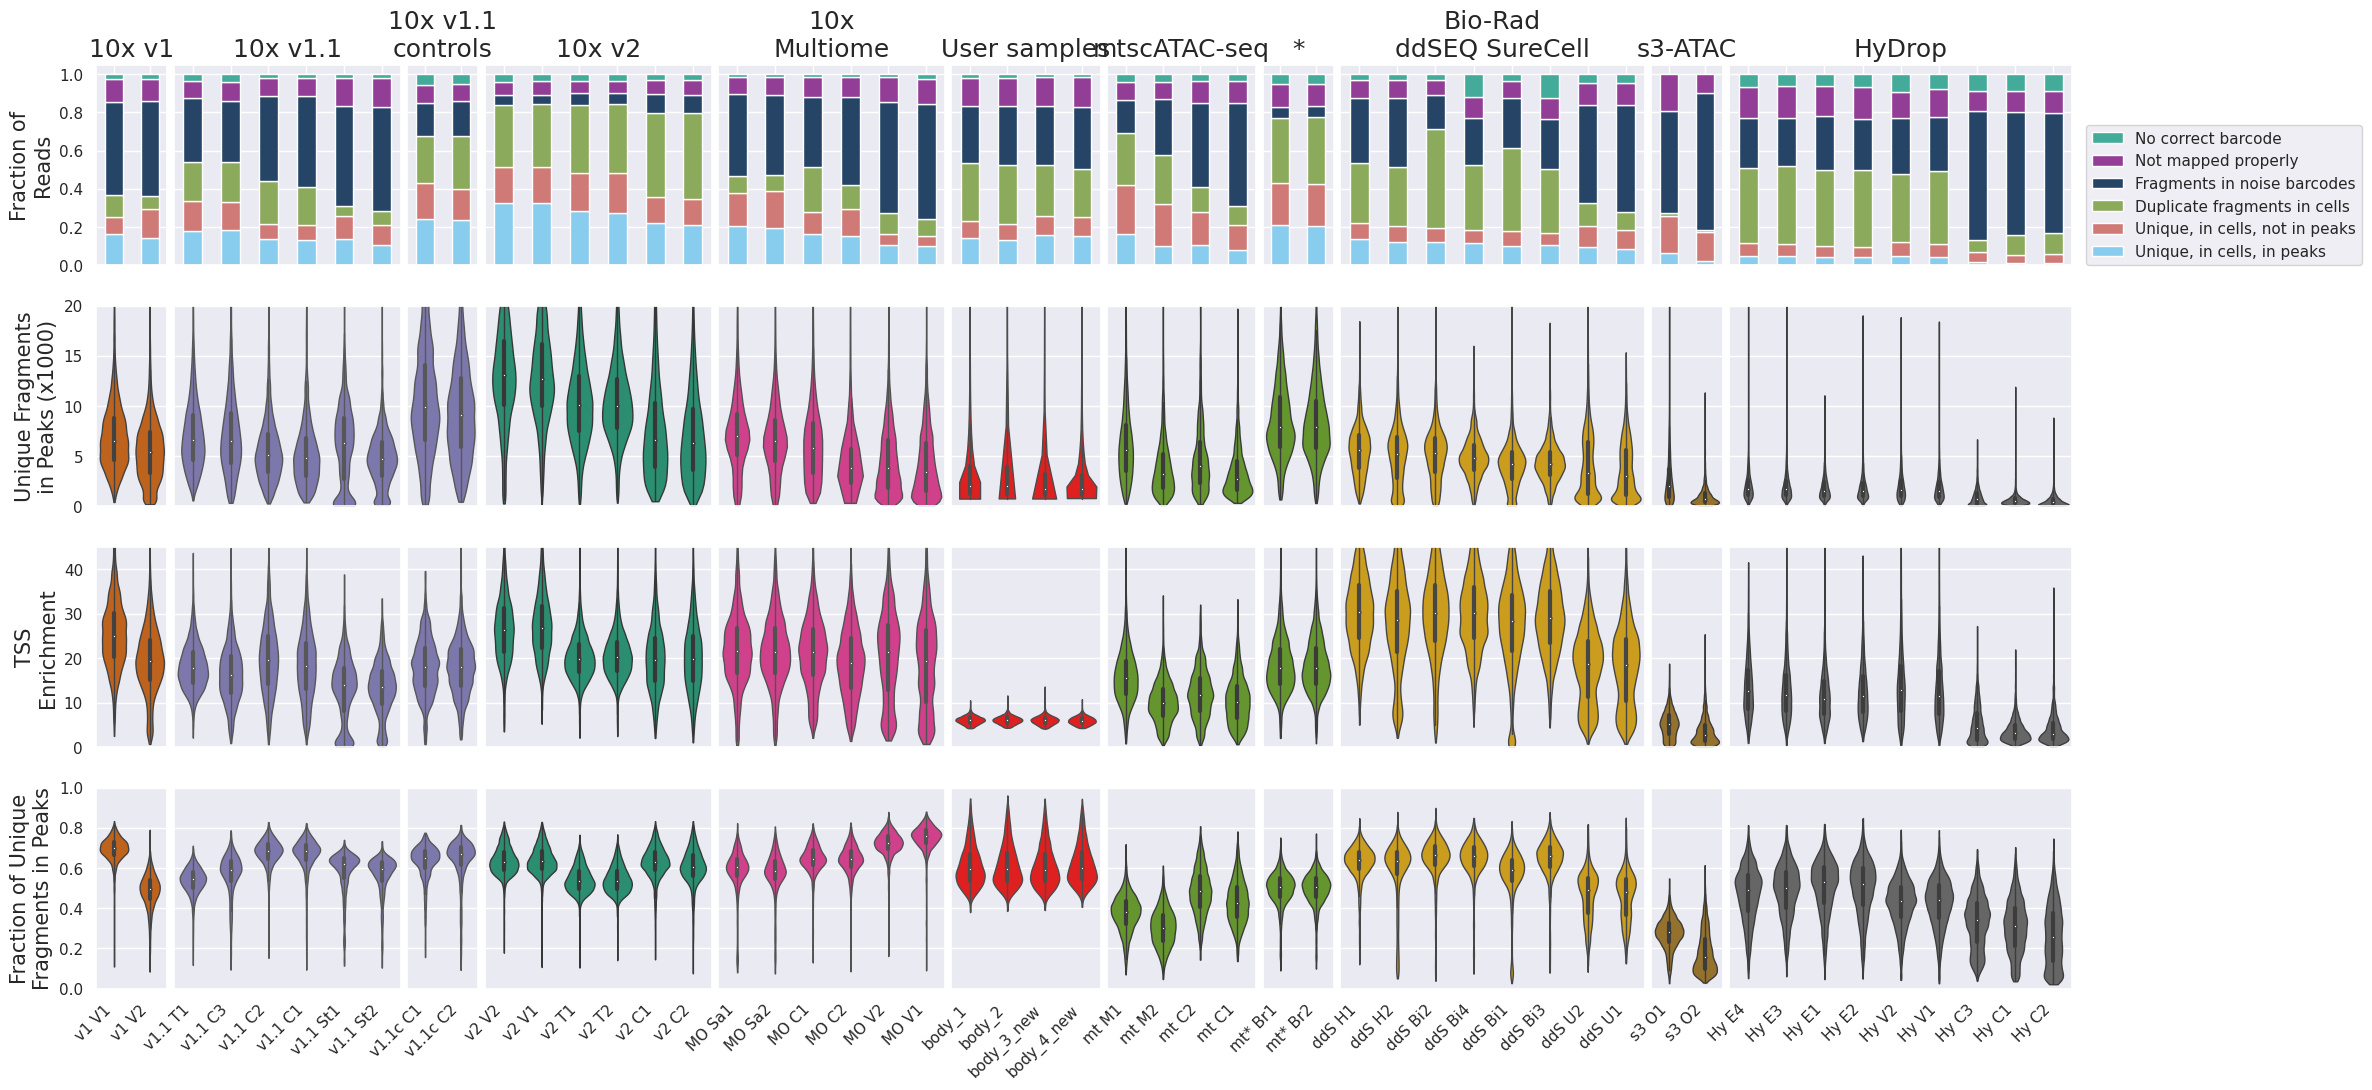

In [53]:
variables_list = ["Unique_nr_frag_in_regions_k", "TSS_enrichment", "FRIP"]

pum.plot_all_qc(
    df_stats_merged,
    df_scstats_merged,
    variables_list,
    sample_order,
    sample_alias_dict,
    tech_order,
    ylim_dict,
    svg_output_path="plots_qc/all_barplots.svg",
    png_output_path="plots_qc/all_barplots.png",
)

Only the user samples:

In [54]:
ymax_frags = (
    df_scstats_merged[df_scstats_merged["tech"] == "user_sample"]
    .groupby("sample_id")["Unique_nr_frag_in_regions"]
    .median()
    .max()
    * 2
)
ymax_frags_k = (
    df_scstats_merged[df_scstats_merged["tech"] == "user_sample"]
    .groupby("sample_id")["Unique_nr_frag_in_regions_k"]
    .median()
    .max()
    * 2
)
ymax_tss = (
    df_scstats_merged[df_scstats_merged["tech"] == "user_sample"]
    .groupby("sample_id")["TSS_enrichment"]
    .median()
    .max()
    * 2
)

ylim_dict = {
    "Unique_nr_frag_in_regions": [0, ymax_frags],
    "Unique_nr_frag_in_regions_k": [0, ymax_frags_k],
    "FRIP": [0, 1],
    "TSS_enrichment": [0, ymax_tss],
}

/lustre1/project/stg_00002/lcb/fderop/data/20230504_PUMATAC_qc_workshop/PUMATAC_tutorial/pypumatac.py:1693: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


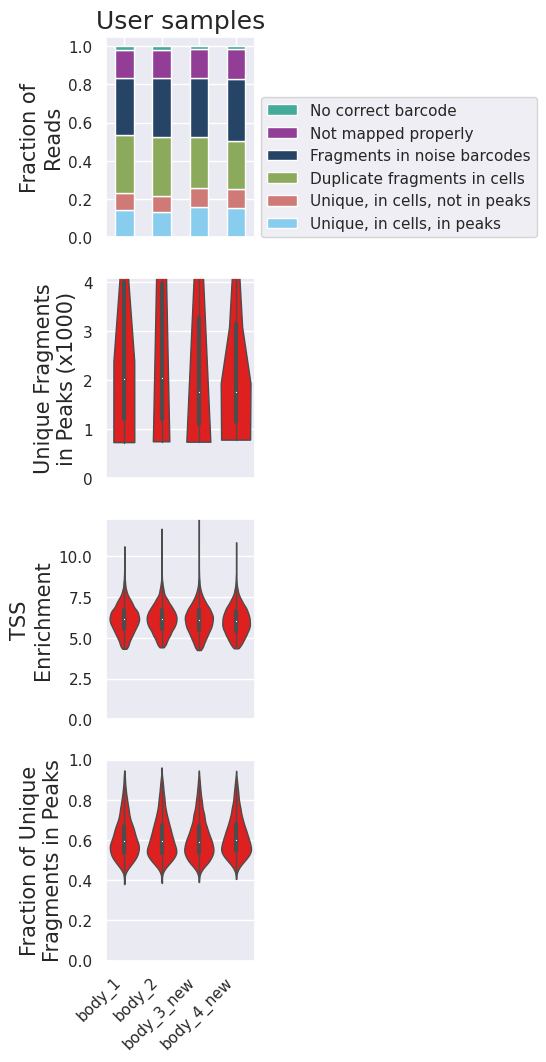

In [55]:
variables_list = ["Unique_nr_frag_in_regions_k", "TSS_enrichment", "FRIP"]

pum.plot_all_qc(
    df_stats_merged,
    df_scstats_merged,
    variables_list,
    sample_order,
    sample_alias_dict,
    ["user_sample"],
    ylim_dict,
    svg_output_path="plots_qc/usersamples_barplots.svg",
    png_output_path="plots_qc/usersamples_barplots.png",
)

# 4. Saturation analysis

The following code subsets the `fragments.tsv.gz` file for selected cells, and then calculates the saturation within these selected cells.

First, load the barcodes we filtered as cells. Make sure that the barcodes match the barcodes in the fragments files! Take special care to remove any suffixes or prefixes that you may have added to the barcodes. For example, cisTopic adds `__{sample}` as a suffix to each barcode:

In [56]:
selected_barcodes_dict = {}
n_cells_dict = {}
for filepath in sorted(glob.glob("selected_barcodes/*pkl")):
    sample = os.path.basename(filepath).split("_bc")[0]
    with open(filepath, "rb") as f:
        selected_barcodes = list(pickle.load(f))
    selected_barcodes = [x.split("___")[0] for x in selected_barcodes]
    newfilepath = filepath.replace(".pkl", ".RAW.txt")
    with open(newfilepath, "w") as fp:
        for item in selected_barcodes:
            fp.write("%s\n" % item)

    selected_barcodes_dict[sample] = selected_barcodes
    n_cells_dict[sample] = len(selected_barcodes)

pp.pprint(n_cells_dict)

{'body_1': 14842, 'body_2': 14085, 'body_3_new': 16208, 'body_4_new': 15167}


Get the number of reads per FASTQ

In [57]:
read_count_dict = {}

if pipeline == "PUMATAC":
    barcode_stats_dict = {
        os.path.basename(x).split(".corrected.bc_stats.log")[0]: x
        for x in sorted(glob.glob(f"{output_dir}/data/reports/barcode/*"))
    }
    barcode_stats_dict

    for sample, filepath in barcode_stats_dict.items():
        if os.path.exists(filepath):
            # print(f"{sample}: {file}")
            df = pd.read_csv(
                filepath, sep="\t\t|\t", engine="python", index_col=0, header=None
            )
            # print(df)
            if "ddseq" in sample:
                nreads = df.loc["nbr_reads:", 1]
                nbarcodes_total = df.loc[
                    "nbr_reads_with_bc1_bc2_bc3_correct_or_correctable", 1
                ]
                percentage_correct_barcodes = nbarcodes_total / nreads * 100
            else:
                nreads = df.loc["nbr_reads:", 1]
                nbarcodes_total = df.loc["total_bc_found", 1]
                percentage_correct_barcodes = nbarcodes_total / nreads * 100

            read_count_dict[sample] = int(nreads)
        else:
            print(f"{file} does not exist!")
elif pipeline == "cellranger-arc":
    stats_dict = {
        x.split("/")[1]: x
        for x in sorted(glob.glob(f"{output_dir}/*/outs/summary.csv"))
    }

    for sample, filepath in stats_dict.items():
        if os.path.exists(filepath):
            df = pd.read_csv(filepath)
            nreads = df["ATAC Sequenced read pairs"]
            percentage_correct_barcodes = df["ATAC Valid barcodes"] * 100
            read_count_dict[sample] = int(nreads)

read_count_dict

{'body_1': 372272309,
 'body_2': 383877604,
 'body_3_new': 312001736,
 'body_4_new': 281388973}

Make a directory where the saturation statistics will be written:

In [58]:
saturation_stats_path = "saturation_stats"
if not os.path.exists(saturation_stats_path):
    os.mkdir(saturation_stats_path)

Check which ones were already run:

In [59]:
sampling_stats_path_dict = {
    x.split("/")[-1].split(".sampling")[0]: x
    for x in sorted(glob.glob(f"{saturation_stats_path}/*.sampling_stats.tsv"))
}
sampling_stats_path_dict

{'BIO_ddseq_4': 'saturation_stats/BIO_ddseq_4.sampling_stats.tsv',
 'EPF_hydrop_1': 'saturation_stats/EPF_hydrop_1.sampling_stats.tsv',
 'OHS_s3atac_1': 'saturation_stats/OHS_s3atac_1.sampling_stats.tsv',
 'TEW__043783__523d9c__Multiome_Liver_10xprotocol': 'saturation_stats/TEW__043783__523d9c__Multiome_Liver_10xprotocol.sampling_stats.tsv',
 'TEW__18d159__fe5107__Multiome_Liver_CCL4': 'saturation_stats/TEW__18d159__fe5107__Multiome_Liver_CCL4.sampling_stats.tsv',
 'TEW__703a9e__28aa75__Multiome_Liver_CTRL': 'saturation_stats/TEW__703a9e__28aa75__Multiome_Liver_CTRL.sampling_stats.tsv',
 'TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1': 'saturation_stats/TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1.sampling_stats.tsv',
 'TEW__872466__dedf23__Multiome_Liver_CTRL1': 'saturation_stats/TEW__872466__dedf23__Multiome_Liver_CTRL1.sampling_stats.tsv',
 'TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2': 'saturation_stats/TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2.sampling_stats.tsv',
 'TEW__95843a__0f

### Calculate the downsampling statistics
We will now downsampled the fragments files at set intervals and calculate quality metrics on these downsampled sets. Then, we will use these datapoints to fit a curve and extrapolate further sequencing saturation.

Define the sampling fractions (levels to which we will downsample the fragments file and calculate saturation):

In [60]:
sampling_fractions = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.97, 1]

### Option #1: Execute the downsampling script using singularity
This is preferred in case you have many fragments files and want to parallelize

In [61]:
raw_barcode_path = {
    os.path.basename(x).split("_bc")[0]: x
    for x in sorted(glob.glob("selected_barcodes/*RAW.txt"))
}
script_path = (
    "PUMATAC_dependencies/single_cell_toolkit/calculate_saturation_from_fragments.py"
)
sif_path = "PUMATAC_dependencies/jupyter_kernels/20230419_pycistopic.sif"
for sample, path in fragments_paths_dict.items():
    command = f"singularity exec -B /lustre1,/staging,/data {sif_path} python {script_path} -i {path} -o {saturation_stats_path}/{sample} -c {raw_barcode_path[sample]} -s {','.join([str(x) for x in sampling_fractions])} &"

    print(command)
    print("\n")

singularity exec -B /lustre1,/staging,/data PUMATAC_dependencies/jupyter_kernels/20230419_pycistopic.sif python PUMATAC_dependencies/single_cell_toolkit/calculate_saturation_from_fragments.py -i outputs_new/body_1/outs/atac_fragments.tsv.gz -o saturation_stats/body_1 -c selected_barcodes/body_1_bc_passing_filters_otsu.RAW.txt -s 0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.97,1 &


singularity exec -B /lustre1,/staging,/data PUMATAC_dependencies/jupyter_kernels/20230419_pycistopic.sif python PUMATAC_dependencies/single_cell_toolkit/calculate_saturation_from_fragments.py -i outputs_new/body_2/outs/atac_fragments.tsv.gz -o saturation_stats/body_2 -c selected_barcodes/body_2_bc_passing_filters_otsu.RAW.txt -s 0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.97,1 &


singularity exec -B /lustre1,/staging,/data PUMATAC_dependencies/jupyter_kernels/20230419_pycistopic.sif python PUMATAC_dependencies/single_cell_toolkit/calculate_saturation_from_fragments.py -i outputs_new/body_3_new/outs/atac_fr

And call these commands in command line. `&` indicates that the command will be submitted as background job.

### Option #2. Run the function directly in this notebook:
Fastest method for a few samples.

In [62]:
covar_dict = {}
best_fit_ab_dict = {}
x_fit_dict = {}
y_fit_dict = {}
pl.enable_string_cache(True)

for sample in list(fragments_paths_dict.keys()):
    print(sample)
    # n_reads = df_reads.loc[sample]["reads"]

    if not sample in sampling_stats_path_dict.keys():
        print(f"{sample} stats do not exist")

        frags_path = fragments_paths_dict[sample]
        fragments_df = pum.read_bc_and_counts_from_fragments_file(frags_path)

        # Sub-sample.
        stats_df = pum.sub_sample_fragments(
            fragments_df=fragments_df,
            selected_barcodes=selected_barcodes_dict[sample],
            sampling_fractions=sampling_fractions,
            stats_tsv_filename=f"{saturation_stats_path}/{sample}.sampling_stats.tsv",
            # whitelist=args.whitelist,
        )

body_1
body_2
body_3_new
body_4_new


### Plotting the saturation
The following files should be generated:

In [63]:
sampling_stats_path_dict = {
    x.split("/")[-1].split(".sampling")[0]: x
    for x in sorted(glob.glob(f"{saturation_stats_path}/*.sampling_stats.tsv"))
}
sampling_stats_path_dict

{'BIO_ddseq_4': 'saturation_stats/BIO_ddseq_4.sampling_stats.tsv',
 'EPF_hydrop_1': 'saturation_stats/EPF_hydrop_1.sampling_stats.tsv',
 'OHS_s3atac_1': 'saturation_stats/OHS_s3atac_1.sampling_stats.tsv',
 'TEW__043783__523d9c__Multiome_Liver_10xprotocol': 'saturation_stats/TEW__043783__523d9c__Multiome_Liver_10xprotocol.sampling_stats.tsv',
 'TEW__18d159__fe5107__Multiome_Liver_CCL4': 'saturation_stats/TEW__18d159__fe5107__Multiome_Liver_CCL4.sampling_stats.tsv',
 'TEW__703a9e__28aa75__Multiome_Liver_CTRL': 'saturation_stats/TEW__703a9e__28aa75__Multiome_Liver_CTRL.sampling_stats.tsv',
 'TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1': 'saturation_stats/TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1.sampling_stats.tsv',
 'TEW__872466__dedf23__Multiome_Liver_CTRL1': 'saturation_stats/TEW__872466__dedf23__Multiome_Liver_CTRL1.sampling_stats.tsv',
 'TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2': 'saturation_stats/TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2.sampling_stats.tsv',
 'TEW__95843a__0f

First, we plot the saturation of median unique fragments per barcode. I also want to find out at which dept I reach 75% of the saturation value (plotted in blue):

In [64]:
percentage_toplot = 0.75

On the x-axis, I want to plot the mean reads per barcode (i.e. the total number of sequenced reads divided by the number of cells), on the y-axis I want the median number of unique fragments, and I also want to indicate the current saturation level (i.e. the saturation of the full, non-sampled fragments file).

I use a michaelis-menten kinetic model to fit these values.

In [65]:
def MM(x, Vmax, Km):
    """
    Define the Michaelis-Menten Kinetics model that will be used for the model fitting.
    """
    if Vmax > 0 and Km > 0:
        y = (Vmax * x) / (Km + x)
    else:
        y = 1e10
    return y

In the following plot, `kRPC` denotes reads per cell (thousands).

In [66]:
sns.set_style("ticks")

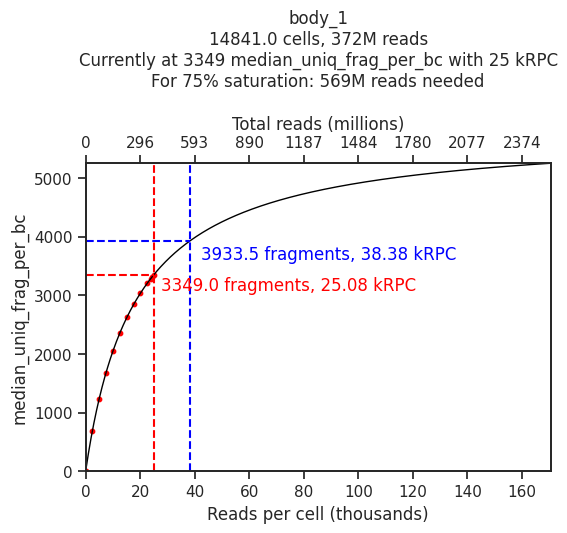

body_1
14841.0 cells, 372M reads
Currently at 3349 median_uniq_frag_per_bc with 25 kRPC
For 75% saturation: 569M reads needed



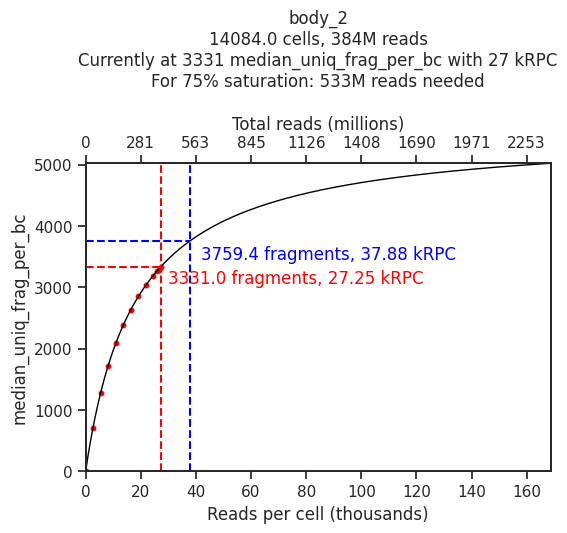

body_2
14084.0 cells, 384M reads
Currently at 3331 median_uniq_frag_per_bc with 27 kRPC
For 75% saturation: 533M reads needed



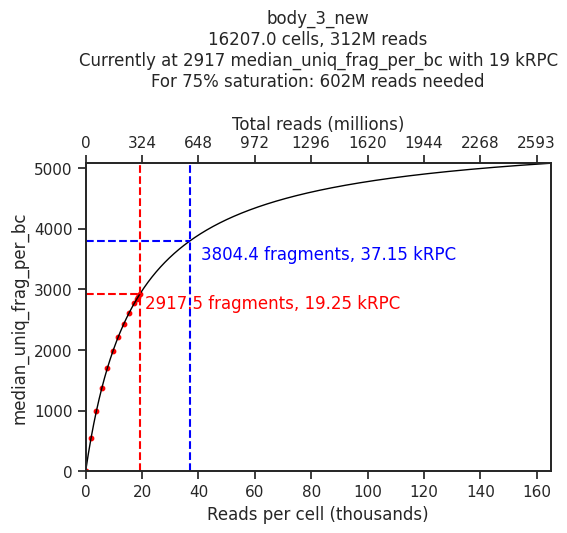

body_3_new
16207.0 cells, 312M reads
Currently at 2917 median_uniq_frag_per_bc with 19 kRPC
For 75% saturation: 602M reads needed



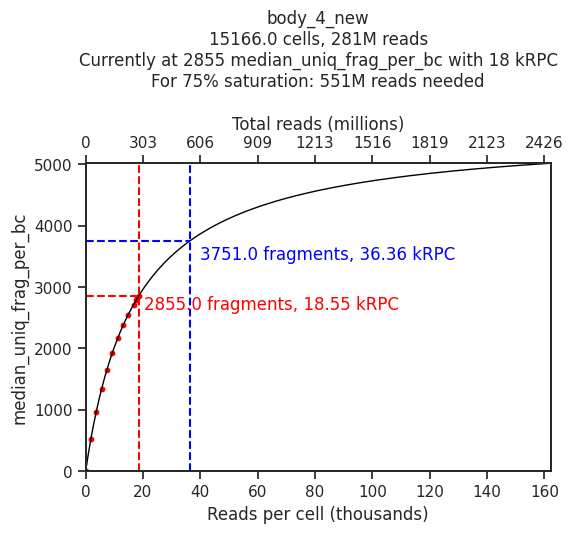

body_4_new
15166.0 cells, 281M reads
Currently at 2855 median_uniq_frag_per_bc with 18 kRPC
For 75% saturation: 551M reads needed



In [67]:
for sample in fragments_paths_dict.keys():
    filepath = sampling_stats_path_dict[sample]
    n_reads = df_stats.at[sample, "n_reads"]
    n_cells = df_stats.at[sample, "n_cells"]

    pum.plot_saturation_fragments(
        filepath,
        sample_alias_dict[sample],
        n_reads,
        n_cells,
        x_axis="mean_reads_per_barcode",
        y_axis="median_uniq_frag_per_bc",
        function=MM,
        percentage_toplot=percentage_toplot,
        plot_current_saturation=True,
        svg_output_path=f"plots_qc/{sample}__fragments_saturation.svg",
        png_output_path=f"plots_qc/{sample}__fragments_saturation.png",
    )

Now, I want the duplication rate (fraction of fragments that are duplicates) on the y-axis instead. I also want to find the depth where 75% of reads are duplicates.

I use a michaelis-menten kinetic model with a maximum value fixed to 1 (number of duplicates cannot exceed 100%) to fit these values.

In [68]:
def MM_duplication(x, Km):
    """
    Define the Michaelis-Menten Kinetics model that will be used for the model fitting.
    """
    if Km > 0:
        y = x / (Km + x)
    else:
        y = 1e10
    return y

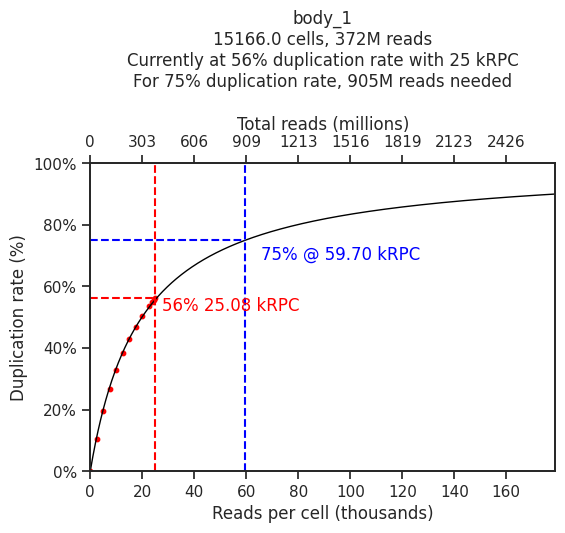

body_1
15166.0 cells, 372M reads
Currently at 56% duplication rate with 25 kRPC
For 75% duplication rate, 905M reads needed



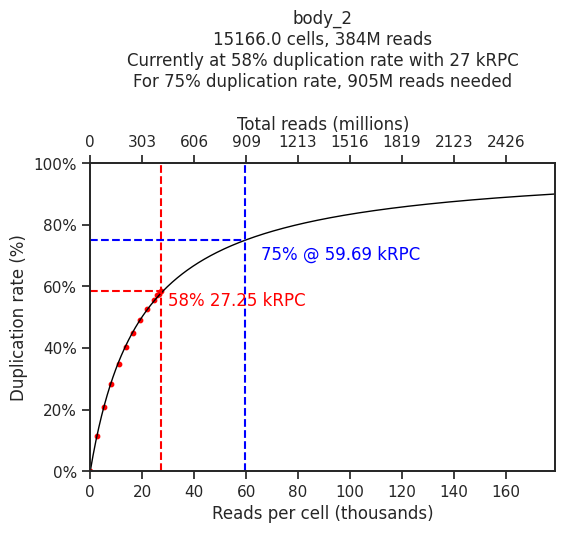

body_2
15166.0 cells, 384M reads
Currently at 58% duplication rate with 27 kRPC
For 75% duplication rate, 905M reads needed



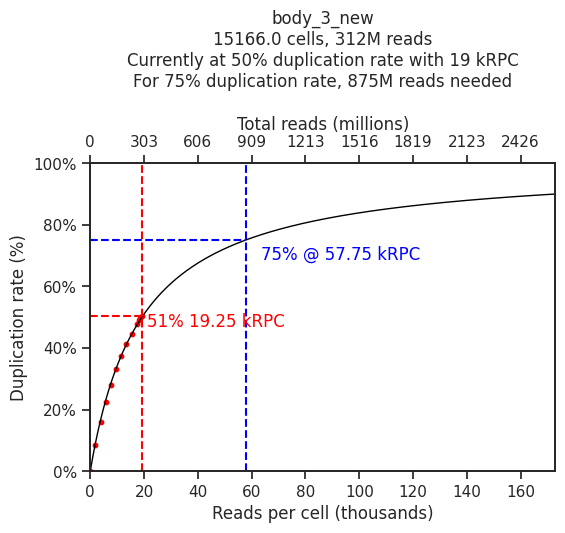

body_3_new
15166.0 cells, 312M reads
Currently at 50% duplication rate with 19 kRPC
For 75% duplication rate, 875M reads needed



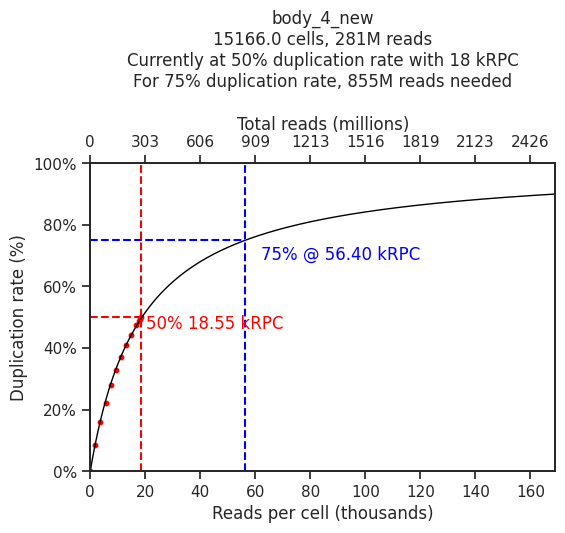

body_4_new
15166.0 cells, 281M reads
Currently at 50% duplication rate with 18 kRPC
For 75% duplication rate, 855M reads needed



In [69]:
for sample in fragments_paths_dict.keys():
    filepath = sampling_stats_path_dict[sample]
    n_reads = read_count_dict[sample]

    pum.plot_saturation_duplication(
        filepath,
        sample_alias_dict[sample],
        n_reads,
        n_cells,
        x_axis="mean_reads_per_barcode",
        y_axis="duplication_rate",
        function=MM_duplication,
        percentage_toplot=percentage_toplot,
        plot_current_saturation=True,
        svg_output_path=f"plots_qc/{sample}__duplication_saturation.svg",
        png_output_path=f"plots_qc/{sample}__duplication_saturation.png",
    )